In [1]:
!pip install optuna
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split, SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import torch.nn.functional as F
import optuna

     |████████████████████████████████| 308 kB 7.7 MB/s 
     |████████████████████████████████| 81 kB 6.5 MB/s 
     |████████████████████████████████| 210 kB 52.0 MB/s 
     |████████████████████████████████| 78 kB 7.1 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 150 kB 55.9 MB/s 
     |████████████████████████████████| 113 kB 45.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=c6638d9e437c03da07da4ea38aa4cbd3253d0881293f64b5968206776246ca19
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# Calculation of mean and std of the fashion mnist dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor() ])
td = torchvision.datasets.FashionMNIST('MNIST_data/', download = True, train = True,transform = transform)
loader = torch.utils.data.DataLoader(td, batch_size = 64, shuffle = False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [3]:
mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)
mean = mean.numpy()[0]
std = std.numpy()[0]
print(f" mean of the training dataset : {mean}")
print(f" std of the training dataset : {std}")

 mean of the training dataset : 0.2860407531261444
 std of the training dataset : 0.320453405380249


### loading Data

In [4]:
# all_transforms = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose(transforms=[transforms.ToTensor() ,
                               transforms.Normalize((mean,), (std,))])
# Download and load the training data
Train_dataset = torchvision.datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
test_dataset = torchvision.datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

train_dataset, val_dataset = random_split(Train_dataset, (50000, 10000))

validationloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = True)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [5]:
def accuracy(a,b):
    acc = 0
    length = len(a)
    blen = len(b)
    if length == blen:
        for index,i in enumerate(a):
            if i == b[index]:
                acc = acc + 1
    else:
        print('lists are not of the same length')
    return acc/length
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#  NN
In this section a simple neural network with 2 fully connected has been defined and trained.
Two function have been defined to perform the training section (function named **train** ) and evaluation section(function named **test_loss** ). 

In [6]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, acctivation = nn.ReLU()):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = acctivation
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

In [ ]:
### these two functions are used for fully connected network

def train(model, loader, optimizer):
    model.train()# Training mode (e.g. enable dropout, batchnorm updates,...)
    lossFn = nn.CrossEntropyLoss()
    ls = []
    acc = []
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x.view(x.shape[0],-1))#------------------------ Forward pass
        loss = lossFn(output, y)#---------- Compute loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()#-------------------------- Update the weights
        ls.append(loss.cpu().detach().numpy())
        acc.append(accuracy(output.argmax(dim=1),y))
    return np.mean(ls),np.mean(acc)
# ---------------------------------------------------------------------------

def test_loss(model,loader):
    loss_function = nn.CrossEntropyLoss()
    model.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    ls = []
    acc = []
    with torch.no_grad(): # Disable gradient tracking
        for xt,yt in loader:
            xt = xt.to(device)
            yt = yt.to(device)
            out1 = model(xt.view(xt.shape[0],-1))
            loss = loss_function(out1, yt)#Compute loss
            ls.append(loss.cpu().detach().cpu().numpy())
            acc.append(accuracy(out1.argmax(dim=1),yt))
    return np.mean(ls),np.mean(acc)


Train fully connected neural network with some initial value

In [ ]:
Ni = 784 #784 = 28*28
Nh1 = 256
Nh2 = 128
No = 10
torch.manual_seed(42)

nnNet = Net(Ni,Nh1,Nh2,No).to(device)
optimizer = optim.SGD(nnNet.parameters(), lr = 0.01,weight_decay = 0.001)

Network initialized


In [ ]:
## TRAINING LOOP
num_epochs = 10
train_loss_log = []
val_loss_log = []
# optimizer = optim.Adam(net.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()
Train_acc = []
val_loss= []
accuracy_val = []
train_loss= []

for epoch_num in range(num_epochs):
    print(f'------------------------------------------ EPOCH {epoch_num + 1} -------------------------------')
    ###------------------------------ TRAIN --------------------------
    TrainLosstemp,TrainAccTemp = train(nnNet, trainloader, optimizer)
    
    Train_acc.append(TrainAccTemp)
    #Save average train loss
    train_loss.append(TrainLosstemp)
    print(f"TRAIN LOSS: {TrainLosstemp}")
    
    
    #------------------------------ VALIDATION --------------------------

    lossTemp,accTemp = test_loss(nnNet,testloader)
    
    val_loss.append(lossTemp)
    accuracy_val.append(accTemp)
    print(f"VAL LOSS: {lossTemp}")
    print(f"VAL accuracy: {accTemp}")
    print(f"Training accuracy: {TrainAccTemp}")
    val_loss_log.append(val_loss)
    

------------------------------------------ EPOCH 1 -------------------------------
TRAIN LOSS: 0.9189713597297668
VAL LOSS: 0.6111071109771729
VAL accuracy: 0.7691082802547771
Training accuracy: 0.714094469309463
------------------------------------------ EPOCH 2 -------------------------------
TRAIN LOSS: 0.5185559391975403
VAL LOSS: 0.5096813440322876
VAL accuracy: 0.8164808917197452
Training accuracy: 0.8164562020460358
------------------------------------------ EPOCH 3 -------------------------------
TRAIN LOSS: 0.4593013823032379
VAL LOSS: 0.47704339027404785
VAL accuracy: 0.8274283439490446
Training accuracy: 0.8373561381074168
------------------------------------------ EPOCH 4 -------------------------------
TRAIN LOSS: 0.42761608958244324
VAL LOSS: 0.5162773132324219
VAL accuracy: 0.8172770700636943
Training accuracy: 0.847346547314578
------------------------------------------ EPOCH 5 -------------------------------
TRAIN LOSS: 0.405568927526474
VAL LOSS: 0.45449182391166687
V

### convolutional NN

In [7]:
class Cnn(nn.Module):
    def __init__(self,numFilters1,numFilters2,kernel,fc1,fc2,p =0):
        """
            numFilters1 is number of filters in the first convolutional layer
            numFilters2 is number of filters in the second convolutional layer
            kernel is the size for kernels used in convolutional layer
            fc1 is number of neurons in the first fully connected layer after convolutional leyars
            fc2 is number of neurons in the second fully connected layer after convolutional leyars
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels = numFilters1,kernel_size = kernel,padding=1)
        self.conv2 = nn.Conv2d(in_channels=numFilters1,out_channels = numFilters2,kernel_size = kernel)
        self.w1 = (28 - kernel +2*1 + 1)/2
        self.w2 = int((self.w1 - kernel + 1)/2)
#         print(self.w2)
        self.fc1 = nn.Linear(in_features=numFilters2*self.w2*self.w2, out_features=fc1)
        self.fc2 = nn.Linear(in_features=fc1, out_features=fc2)
        self.out = nn.Linear(in_features=fc2, out_features=10)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p)
        print('CNN has been initialized')
    def forward(self,x):
        x = self.act(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = self.act(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.shape[0], -1)
        x = self.dropout(self.act(self.fc1(x)))
        x = self.dropout(self.act(self.fc2(x)))
        x = self.out(x)
        return x

In [8]:
# from torch.cuda import device
def TrainCNN(model, loader, optimizer):
    model.train()# Training mode (e.g. enable dropout, batchnorm updates,...)
    lossFn = nn.CrossEntropyLoss()
    acc = []
    ls = []
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)#------------------------ Forward pass
        loss = lossFn(output, y)#---------- Compute loss
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()#-------------------------- Update the weights
        ls.append(loss.cpu().detach().numpy())
        acc.append(accuracy(output.argmax(dim=1),y))
    return np.mean(ls),np.mean(acc)

In [9]:
def test_loss_Cnn(model,loader):
    acc = []
    ls = []
    loss_function = nn.CrossEntropyLoss()
    model.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for xt,yt in loader:
            xt = xt.to(device)
            yt = yt.to(device)
            out1 = model(xt)
            loss = loss_function(out1, yt)#Compute loss
            ls.append(loss.cpu().detach().cpu().numpy())
            acc.append(accuracy(out1.argmax(dim=1),yt))
        return np.mean(ls),np.mean(acc)

In [ ]:
# {'lr': 0.0012225257114034166, 'momentum': 0.9456193076756049, 'optimizer': 'Adam', 'p': 0.2870436463863079, 'layerOne': 58.0, 'layerTwo': 34.0, 'fc1': 64.0, 'fc2': 32.0}.
net = Cnn(58,34,kernel=5,fc1=64,fc2 = 32).to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.0012)

CNN has been initialized


In this part we trained the network with some initial parameters.
 We used training data for training network and test data for validation error and accuracy

In [ ]:
## TRAINING LOOP
num_epochs = 10
train_loss_log = []
val_loss_log = []
# optimizer = optim.Adam(net.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()
Train_acc = []
val_loss= []
accuracy_val = []
train_loss= []
for epoch_num in range(num_epochs):
    print(f'------------------------------------------ EPOCH {epoch_num + 1} -------------------------------')
    ###------------------------------ TRAIN --------------------------
    TrainLosstemp,TrainAccTemp = TrainCNN(net, trainloader, optimizer)
    
    Train_acc.append(TrainAccTemp)
    #Save average train loss
    train_loss.append(TrainLosstemp)
    print(f"TRAIN LOSS: {TrainLosstemp}")
    
    
    #------------------------------ VALIDATION --------------------------

    lossTemp,accTemp = test_loss_Cnn(net,testloader)
    
    val_loss.append(lossTemp)
    accuracy_val.append(accTemp)
    print(f"VAL LOSS: {lossTemp}")
    print(f"VAL accuracy: {accTemp}")
    print(f"Training accuracy: {TrainAccTemp}")
    val_loss_log.append(val_loss)
    

------------------------------------------ EPOCH 1 -------------------------------
TRAIN LOSS: 0.5563516020774841
VAL LOSS: 0.43716052174568176
VAL accuracy: 0.8416600318471338
Training accuracy: 0.7960557864450127
------------------------------------------ EPOCH 2 -------------------------------
TRAIN LOSS: 0.3529829978942871
VAL LOSS: 0.338035523891449
VAL accuracy: 0.8772890127388535
Training accuracy: 0.8716831841432225
------------------------------------------ EPOCH 3 -------------------------------
TRAIN LOSS: 0.3007872700691223
VAL LOSS: 0.3548182547092438
VAL accuracy: 0.8698248407643312
Training accuracy: 0.8891863810741688
------------------------------------------ EPOCH 4 -------------------------------
TRAIN LOSS: 0.2674252986907959
VAL LOSS: 0.2971368730068207
VAL accuracy: 0.8938097133757962
Training accuracy: 0.9020540281329923
------------------------------------------ EPOCH 5 -------------------------------
TRAIN LOSS: 0.24447360634803772
VAL LOSS: 0.29731088876724243

# Optimizing Hyperparameters
In this part we choose some hyperparameters to optimize them using Optuna
Hyperparameters are: 
1. number of filters of first channel
2. number of filters of second channel 
3. Optimizer 
4. dropout probability (a regularization method)
5. number of neurons in the first fully connected layer
6. number of neurons in the second fully connected layer
7. the momentum parameter in SGD optimizer (regularizatiom method)
8. L2 weight (regularizatiom method)

Number of epochs that every network is trained is set to 10.

The hole number of trials for Optuna is set to 100.

In [ ]:
def obj(trial):
    cfg = { 
          'device' : "cuda" if torch.cuda.is_available() else "cpu",
          'n_epochs' : 10,
          'seed' : 0,
          'log_interval' : 100,
          'save_model' : False,
          'lr' : trial.suggest_loguniform('lr', 9e-4, 9e-2),
          'momentum': trial.suggest_uniform('momentum', 0.85, 0.95),
          'optimizer': trial.suggest_categorical('optimizer',["SGD", "RAdam","Adam"]),
          'p':trial.suggest_uniform('p', 0, 0.3),
          'layerOne': trial.suggest_discrete_uniform('layerOne', 30, 62,4), 
          'layerTwo': trial.suggest_discrete_uniform('layerTwo', 30, 62,4), 
          'fc1': trial.suggest_discrete_uniform('fc1', 64, 128, 8), 
          'fc2': trial.suggest_discrete_uniform('fc2', 32, 64, 8),
          }

    torch.manual_seed(cfg['seed'])
    model = Cnn(numFilters1=int(cfg['layerOne']),numFilters2=int(cfg['layerTwo']),kernel=5,fc1=int(cfg['fc1']),
                fc2=int(cfg['fc2']),p=cfg['p'])
    model.to(cfg['device'])
    if cfg['optimizer']=="SGD":
        # print(cfg['optimizer'])
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'],momentum = cfg['momentum'])
    else:
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'])
 
    for epoch in range(1, cfg['n_epochs'] + 1):
        _,accuracy = TrainCNN( model,trainloader , optimizer)
 # ----------- the next few lines are Optuna pruning which is a kind of early stopping to run the algorith with pruning uncomment these lines       
        # trial.report(accuracy, epoch)
        # # Handle pruning based on the intermediate value.
        # if trial.should_prune():
        #     print(epoch)
        #     print(accuracy)
        #     raise optuna.exceptions.TrialPruned()
    _,Accuracy_validation =(test_loss_Cnn(model,validationloader))

    return Accuracy_validation

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(obj, n_trials=100, timeout=100000)

[I 2022-03-06 08:04:36,973] A new study created in memory with name: no-name-0ebbbbb8-c26d-48cc-ac25-df42e27405d3


CNN has been initialized


[I 2022-03-06 08:05:50,568] Trial 0 finished with value: 0.8695700354609929 and parameters: {'lr': 0.009741969264466013, 'momentum': 0.8586031941811639, 'optimizer': 'Adam', 'p': 0.03496734700608316, 'layerOne': 34.0, 'layerTwo': 46.0, 'fc1': 80.0, 'fc2': 48.0}. Best is trial 0 with value: 0.8695700354609929.


CNN has been initialized


[I 2022-03-06 08:07:05,876] Trial 1 finished with value: 0.6660017730496454 and parameters: {'lr': 0.040268606187834614, 'momentum': 0.8809852915484017, 'optimizer': 'RAdam', 'p': 0.23004961276875308, 'layerOne': 58.0, 'layerTwo': 34.0, 'fc1': 128.0, 'fc2': 40.0}. Best is trial 0 with value: 0.8695700354609929.


CNN has been initialized


[I 2022-03-06 08:08:20,651] Trial 2 finished with value: 0.8711214539007093 and parameters: {'lr': 0.0017998557987508985, 'momentum': 0.9276064729611728, 'optimizer': 'SGD', 'p': 0.03221465793967355, 'layerOne': 58.0, 'layerTwo': 58.0, 'fc1': 112.0, 'fc2': 64.0}. Best is trial 2 with value: 0.8711214539007093.


CNN has been initialized


[I 2022-03-06 08:09:35,646] Trial 3 finished with value: 0.8954454787234043 and parameters: {'lr': 0.03579397145857065, 'momentum': 0.8633840557917886, 'optimizer': 'SGD', 'p': 0.127320973441077, 'layerOne': 62.0, 'layerTwo': 62.0, 'fc1': 88.0, 'fc2': 48.0}. Best is trial 3 with value: 0.8954454787234043.


CNN has been initialized


[I 2022-03-06 08:10:50,001] Trial 4 finished with value: 0.9018727836879432 and parameters: {'lr': 0.0029690927722427238, 'momentum': 0.9152274079030636, 'optimizer': 'Adam', 'p': 0.08360883333231592, 'layerOne': 50.0, 'layerTwo': 50.0, 'fc1': 88.0, 'fc2': 64.0}. Best is trial 4 with value: 0.9018727836879432.


CNN has been initialized


[I 2022-03-06 08:12:05,307] Trial 5 finished with value: 0.8983266843971631 and parameters: {'lr': 0.020958280449112625, 'momentum': 0.8960968430217973, 'optimizer': 'SGD', 'p': 0.2123705573671254, 'layerOne': 58.0, 'layerTwo': 46.0, 'fc1': 104.0, 'fc2': 64.0}. Best is trial 4 with value: 0.9018727836879432.


CNN has been initialized


[I 2022-03-06 08:13:20,156] Trial 6 finished with value: 0.8492353723404256 and parameters: {'lr': 0.001208970356073041, 'momentum': 0.9382850774568687, 'optimizer': 'SGD', 'p': 0.17874703792131952, 'layerOne': 62.0, 'layerTwo': 54.0, 'fc1': 72.0, 'fc2': 48.0}. Best is trial 4 with value: 0.9018727836879432.


CNN has been initialized


[I 2022-03-06 08:14:35,227] Trial 7 finished with value: 0.903978280141844 and parameters: {'lr': 0.0030625905297419023, 'momentum': 0.8991803211386731, 'optimizer': 'Adam', 'p': 0.222531892965696, 'layerOne': 58.0, 'layerTwo': 62.0, 'fc1': 80.0, 'fc2': 64.0}. Best is trial 7 with value: 0.903978280141844.


CNN has been initialized


[I 2022-03-06 08:15:50,863] Trial 8 finished with value: 0.8661347517730497 and parameters: {'lr': 0.012301726660725957, 'momentum': 0.9231120934508493, 'optimizer': 'RAdam', 'p': 0.02804264233971041, 'layerOne': 62.0, 'layerTwo': 58.0, 'fc1': 88.0, 'fc2': 40.0}. Best is trial 7 with value: 0.903978280141844.


CNN has been initialized


[I 2022-03-06 08:17:05,272] Trial 9 finished with value: 0.8997118794326241 and parameters: {'lr': 0.002179580488970219, 'momentum': 0.9393967747787486, 'optimizer': 'RAdam', 'p': 0.02220856574355121, 'layerOne': 38.0, 'layerTwo': 54.0, 'fc1': 104.0, 'fc2': 56.0}. Best is trial 7 with value: 0.903978280141844.


CNN has been initialized


[I 2022-03-06 08:18:20,243] Trial 10 finished with value: 0.8742796985815603 and parameters: {'lr': 0.0055137405322370076, 'momentum': 0.8959409094628732, 'optimizer': 'Adam', 'p': 0.29938322111042454, 'layerOne': 46.0, 'layerTwo': 38.0, 'fc1': 64.0, 'fc2': 32.0}. Best is trial 7 with value: 0.903978280141844.


CNN has been initialized


[I 2022-03-06 08:19:34,316] Trial 11 finished with value: 0.8880762411347518 and parameters: {'lr': 0.004655457308550189, 'momentum': 0.9113679194040076, 'optimizer': 'Adam', 'p': 0.10880812141660826, 'layerOne': 50.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 64.0}. Best is trial 7 with value: 0.903978280141844.


CNN has been initialized


[I 2022-03-06 08:20:59,258] Trial 12 finished with value: 0.8960549645390071 and parameters: {'lr': 0.0033624142038479825, 'momentum': 0.9136132791877283, 'optimizer': 'Adam', 'p': 0.08854252183476127, 'layerOne': 50.0, 'layerTwo': 42.0, 'fc1': 64.0, 'fc2': 56.0}. Best is trial 7 with value: 0.903978280141844.


CNN has been initialized


[I 2022-03-06 08:22:17,039] Trial 13 finished with value: 0.10089760638297872 and parameters: {'lr': 0.08689848537959156, 'momentum': 0.8832331630538975, 'optimizer': 'Adam', 'p': 0.2672052901657932, 'layerOne': 46.0, 'layerTwo': 30.0, 'fc1': 96.0, 'fc2': 56.0}. Best is trial 7 with value: 0.903978280141844.


CNN has been initialized


[I 2022-03-06 08:23:32,477] Trial 14 finished with value: 0.9041445035460993 and parameters: {'lr': 0.000969136916079564, 'momentum': 0.9081980323759042, 'optimizer': 'Adam', 'p': 0.166202192889041, 'layerOne': 50.0, 'layerTwo': 62.0, 'fc1': 80.0, 'fc2': 64.0}. Best is trial 14 with value: 0.9041445035460993.


CNN has been initialized


[I 2022-03-06 08:24:47,699] Trial 15 finished with value: 0.9036458333333334 and parameters: {'lr': 0.0009283115341494276, 'momentum': 0.8765969289536896, 'optimizer': 'Adam', 'p': 0.1758718202535775, 'layerOne': 42.0, 'layerTwo': 62.0, 'fc1': 72.0, 'fc2': 56.0}. Best is trial 14 with value: 0.9041445035460993.


CNN has been initialized


[I 2022-03-06 08:26:02,781] Trial 16 finished with value: 0.9019281914893617 and parameters: {'lr': 0.0017118423522261557, 'momentum': 0.9037603459372622, 'optimizer': 'Adam', 'p': 0.22350123870537875, 'layerOne': 54.0, 'layerTwo': 62.0, 'fc1': 80.0, 'fc2': 64.0}. Best is trial 14 with value: 0.9041445035460993.


CNN has been initialized


[I 2022-03-06 08:27:12,098] Trial 17 finished with value: 0.9025376773049646 and parameters: {'lr': 0.001026806982618584, 'momentum': 0.8908969258318853, 'optimizer': 'Adam', 'p': 0.16265289649786974, 'layerOne': 30.0, 'layerTwo': 58.0, 'fc1': 72.0, 'fc2': 56.0}. Best is trial 14 with value: 0.9041445035460993.


CNN has been initialized


[I 2022-03-06 08:28:27,428] Trial 18 finished with value: 0.8792664007092199 and parameters: {'lr': 0.006093190372654388, 'momentum': 0.9477152221678959, 'optimizer': 'Adam', 'p': 0.25354650794820693, 'layerOne': 54.0, 'layerTwo': 54.0, 'fc1': 96.0, 'fc2': 64.0}. Best is trial 14 with value: 0.9041445035460993.


CNN has been initialized


[I 2022-03-06 08:29:42,899] Trial 19 finished with value: 0.895279255319149 and parameters: {'lr': 0.0026993441909710044, 'momentum': 0.8700656175061281, 'optimizer': 'RAdam', 'p': 0.1969766244144563, 'layerOne': 42.0, 'layerTwo': 62.0, 'fc1': 128.0, 'fc2': 32.0}. Best is trial 14 with value: 0.9041445035460993.


CNN has been initialized


[I 2022-03-06 08:30:57,655] Trial 20 finished with value: 0.9080784574468085 and parameters: {'lr': 0.001305228236502578, 'momentum': 0.9077298807278527, 'optimizer': 'Adam', 'p': 0.14692545646166455, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 20 with value: 0.9080784574468085.


CNN has been initialized


[I 2022-03-06 08:32:13,756] Trial 21 finished with value: 0.9101285460992907 and parameters: {'lr': 0.0015288250566821875, 'momentum': 0.9041148452970966, 'optimizer': 'Adam', 'p': 0.14372488895412977, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:33:28,711] Trial 22 finished with value: 0.9055851063829787 and parameters: {'lr': 0.001380942973183351, 'momentum': 0.905849850671216, 'optimizer': 'Adam', 'p': 0.13782743702084665, 'layerOne': 54.0, 'layerTwo': 46.0, 'fc1': 72.0, 'fc2': 40.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:34:46,948] Trial 23 finished with value: 0.9029255319148937 and parameters: {'lr': 0.0016380368058215113, 'momentum': 0.9204874077517806, 'optimizer': 'Adam', 'p': 0.13690750898246604, 'layerOne': 54.0, 'layerTwo': 42.0, 'fc1': 64.0, 'fc2': 40.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:36:01,747] Trial 24 finished with value: 0.9097406914893617 and parameters: {'lr': 0.0015693594196947765, 'momentum': 0.891569310923333, 'optimizer': 'Adam', 'p': 0.06937983900916707, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 72.0, 'fc2': 40.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:37:18,012] Trial 25 finished with value: 0.8981050531914894 and parameters: {'lr': 0.004024706557291228, 'momentum': 0.8883560820209753, 'optimizer': 'Adam', 'p': 0.05454080285511373, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 88.0, 'fc2': 32.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:38:38,299] Trial 26 finished with value: 0.9013187056737588 and parameters: {'lr': 0.0020499478911644225, 'momentum': 0.8511355705118775, 'optimizer': 'Adam', 'p': 0.0006984704773260325, 'layerOne': 46.0, 'layerTwo': 42.0, 'fc1': 72.0, 'fc2': 40.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:39:54,015] Trial 27 finished with value: 0.8793772163120568 and parameters: {'lr': 0.006646466289017131, 'momentum': 0.8900877171838245, 'optimizer': 'Adam', 'p': 0.10786329345224488, 'layerOne': 50.0, 'layerTwo': 50.0, 'fc1': 64.0, 'fc2': 48.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:41:09,402] Trial 28 finished with value: 0.8117796985815603 and parameters: {'lr': 0.0013230481046638178, 'momentum': 0.8746045943714723, 'optimizer': 'SGD', 'p': 0.08319102627816435, 'layerOne': 42.0, 'layerTwo': 46.0, 'fc1': 104.0, 'fc2': 40.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:42:27,656] Trial 29 finished with value: 0.8662455673758865 and parameters: {'lr': 0.011838487284966828, 'momentum': 0.9310862683479373, 'optimizer': 'RAdam', 'p': 0.07032461343662073, 'layerOne': 58.0, 'layerTwo': 46.0, 'fc1': 80.0, 'fc2': 32.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:43:42,384] Trial 30 finished with value: 0.909020390070922 and parameters: {'lr': 0.0023675741536925373, 'momentum': 0.9040870959093615, 'optimizer': 'Adam', 'p': 0.11435208905586883, 'layerOne': 54.0, 'layerTwo': 54.0, 'fc1': 88.0, 'fc2': 48.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:44:57,346] Trial 31 finished with value: 0.9009862588652482 and parameters: {'lr': 0.0022021375255591403, 'momentum': 0.9058112447205781, 'optimizer': 'Adam', 'p': 0.11219668937083399, 'layerOne': 54.0, 'layerTwo': 54.0, 'fc1': 88.0, 'fc2': 48.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:46:12,451] Trial 32 finished with value: 0.9089649822695035 and parameters: {'lr': 0.0013469151118720487, 'momentum': 0.90044496518329, 'optimizer': 'Adam', 'p': 0.15276166159465063, 'layerOne': 58.0, 'layerTwo': 50.0, 'fc1': 96.0, 'fc2': 40.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:47:27,895] Trial 33 finished with value: 0.9069148936170213 and parameters: {'lr': 0.002415503497853296, 'momentum': 0.8844151222252679, 'optimizer': 'Adam', 'p': 0.048322817552317085, 'layerOne': 58.0, 'layerTwo': 54.0, 'fc1': 96.0, 'fc2': 48.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:48:43,300] Trial 34 finished with value: 0.9049756205673759 and parameters: {'lr': 0.0015721661135424173, 'momentum': 0.8962174030526927, 'optimizer': 'Adam', 'p': 0.119142480325206, 'layerOne': 62.0, 'layerTwo': 50.0, 'fc1': 120.0, 'fc2': 40.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:49:59,480] Trial 35 finished with value: 0.8646941489361702 and parameters: {'lr': 0.008147649529341662, 'momentum': 0.9022550231230912, 'optimizer': 'Adam', 'p': 0.15417044142420866, 'layerOne': 58.0, 'layerTwo': 58.0, 'fc1': 88.0, 'fc2': 48.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:51:14,741] Trial 36 finished with value: 0.8759973404255319 and parameters: {'lr': 0.00360779647531471, 'momentum': 0.9189548674818198, 'optimizer': 'SGD', 'p': 0.19607260792583633, 'layerOne': 58.0, 'layerTwo': 50.0, 'fc1': 112.0, 'fc2': 32.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:52:30,117] Trial 37 finished with value: 0.8941710992907801 and parameters: {'lr': 0.0019410605004969638, 'momentum': 0.8913529065357305, 'optimizer': 'RAdam', 'p': 0.10161822053445856, 'layerOne': 62.0, 'layerTwo': 54.0, 'fc1': 96.0, 'fc2': 40.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:53:44,217] Trial 38 finished with value: 0.8152149822695035 and parameters: {'lr': 0.001076116617274492, 'momentum': 0.8987708698242832, 'optimizer': 'SGD', 'p': 0.06567174171657574, 'layerOne': 50.0, 'layerTwo': 38.0, 'fc1': 112.0, 'fc2': 48.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:55:00,120] Trial 39 finished with value: 0.7695035460992907 and parameters: {'lr': 0.0270638874069313, 'momentum': 0.8673170898213314, 'optimizer': 'Adam', 'p': 0.12919710060666387, 'layerOne': 62.0, 'layerTwo': 46.0, 'fc1': 88.0, 'fc2': 40.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:56:15,686] Trial 40 finished with value: 0.9066378546099291 and parameters: {'lr': 0.002703600749169495, 'momentum': 0.8795370882669062, 'optimizer': 'Adam', 'p': 0.0940883008369245, 'layerOne': 58.0, 'layerTwo': 54.0, 'fc1': 104.0, 'fc2': 48.0}. Best is trial 21 with value: 0.9101285460992907.


CNN has been initialized


[I 2022-03-06 08:57:31,362] Trial 41 finished with value: 0.9114029255319149 and parameters: {'lr': 0.0013610685611337011, 'momentum': 0.9131521113862375, 'optimizer': 'Adam', 'p': 0.15349691624772488, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 08:58:46,538] Trial 42 finished with value: 0.9089095744680851 and parameters: {'lr': 0.001480424488720812, 'momentum': 0.9168788091637938, 'optimizer': 'Adam', 'p': 0.18496981833222476, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:00:00,949] Trial 43 finished with value: 0.9092974290780141 and parameters: {'lr': 0.0012180452303625468, 'momentum': 0.9250325313725446, 'optimizer': 'Adam', 'p': 0.1453664173354999, 'layerOne': 50.0, 'layerTwo': 50.0, 'fc1': 72.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:01:16,014] Trial 44 finished with value: 0.8916777482269503 and parameters: {'lr': 0.0018697027523224966, 'momentum': 0.9272820114928334, 'optimizer': 'Adam', 'p': 0.12020318982341102, 'layerOne': 50.0, 'layerTwo': 58.0, 'fc1': 72.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:02:30,487] Trial 45 finished with value: 0.9078568262411347 and parameters: {'lr': 0.0011890049963843843, 'momentum': 0.9256164808859216, 'optimizer': 'Adam', 'p': 0.13514190140237853, 'layerOne': 50.0, 'layerTwo': 54.0, 'fc1': 72.0, 'fc2': 32.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:03:45,607] Trial 46 finished with value: 0.8786015070921985 and parameters: {'lr': 0.0024350113394761676, 'momentum': 0.9313089030749434, 'optimizer': 'SGD', 'p': 0.08127700024051256, 'layerOne': 46.0, 'layerTwo': 58.0, 'fc1': 72.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:05:00,161] Trial 47 finished with value: 0.8992132092198581 and parameters: {'lr': 0.0009166237853553465, 'momentum': 0.9136647175256043, 'optimizer': 'RAdam', 'p': 0.17243946909583352, 'layerOne': 50.0, 'layerTwo': 42.0, 'fc1': 80.0, 'fc2': 48.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:06:15,243] Trial 48 finished with value: 0.10089760638297872 and parameters: {'lr': 0.07821524693424559, 'momentum': 0.909364595456842, 'optimizer': 'Adam', 'p': 0.14554257468548756, 'layerOne': 54.0, 'layerTwo': 46.0, 'fc1': 64.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:07:30,866] Trial 49 finished with value: 0.88458554964539 and parameters: {'lr': 0.0030891136869991057, 'momentum': 0.8945505207480438, 'optimizer': 'Adam', 'p': 0.18786156185581637, 'layerOne': 46.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 48.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:08:46,941] Trial 50 finished with value: 0.903091755319149 and parameters: {'lr': 0.0017113048825525062, 'momentum': 0.9397636382486817, 'optimizer': 'Adam', 'p': 0.205107698787748, 'layerOne': 54.0, 'layerTwo': 54.0, 'fc1': 88.0, 'fc2': 32.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:10:03,549] Trial 51 finished with value: 0.9066378546099291 and parameters: {'lr': 0.001174938202679257, 'momentum': 0.9002126241562891, 'optimizer': 'Adam', 'p': 0.15880512305096706, 'layerOne': 58.0, 'layerTwo': 50.0, 'fc1': 96.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:11:19,083] Trial 52 finished with value: 0.9033133865248227 and parameters: {'lr': 0.0014181170753352027, 'momentum': 0.9154925478827453, 'optimizer': 'Adam', 'p': 0.12553747367448337, 'layerOne': 58.0, 'layerTwo': 50.0, 'fc1': 88.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:12:34,291] Trial 53 finished with value: 0.9058067375886525 and parameters: {'lr': 0.0011672271054987823, 'momentum': 0.9121623465262036, 'optimizer': 'Adam', 'p': 0.15106097700913132, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 72.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:13:48,646] Trial 54 finished with value: 0.8795434397163121 and parameters: {'lr': 0.004617150246405238, 'momentum': 0.9226510238820445, 'optimizer': 'Adam', 'p': 0.1686031870273439, 'layerOne': 50.0, 'layerTwo': 46.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:15:03,774] Trial 55 finished with value: 0.8301196808510638 and parameters: {'lr': 0.01632673154689247, 'momentum': 0.9025778486923024, 'optimizer': 'Adam', 'p': 0.09956779478607491, 'layerOne': 54.0, 'layerTwo': 54.0, 'fc1': 104.0, 'fc2': 48.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:16:19,152] Trial 56 finished with value: 0.9041999113475178 and parameters: {'lr': 0.0018896271200940342, 'momentum': 0.8940369990312879, 'optimizer': 'Adam', 'p': 0.14353550374234986, 'layerOne': 58.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 32.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:17:33,175] Trial 57 finished with value: 0.90021054964539 and parameters: {'lr': 0.001025951387962118, 'momentum': 0.8994235248997952, 'optimizer': 'Adam', 'p': 0.24137539294475824, 'layerOne': 34.0, 'layerTwo': 54.0, 'fc1': 64.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:18:47,186] Trial 58 finished with value: 0.9027593085106383 and parameters: {'lr': 0.0014314935241329157, 'momentum': 0.8846356340801337, 'optimizer': 'RAdam', 'p': 0.016902910588097397, 'layerOne': 50.0, 'layerTwo': 30.0, 'fc1': 88.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:20:02,127] Trial 59 finished with value: 0.900709219858156 and parameters: {'lr': 0.002221635570747284, 'momentum': 0.9095136382068356, 'optimizer': 'Adam', 'p': 0.15893115888992643, 'layerOne': 54.0, 'layerTwo': 46.0, 'fc1': 72.0, 'fc2': 48.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:21:17,313] Trial 60 finished with value: 0.910405585106383 and parameters: {'lr': 0.0009065650151284347, 'momentum': 0.9051641260523526, 'optimizer': 'Adam', 'p': 0.04534534174444446, 'layerOne': 62.0, 'layerTwo': 42.0, 'fc1': 96.0, 'fc2': 56.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:22:32,197] Trial 61 finished with value: 0.9076906028368794 and parameters: {'lr': 0.0009132940491823439, 'momentum': 0.9059051031221713, 'optimizer': 'Adam', 'p': 0.0399934003787018, 'layerOne': 62.0, 'layerTwo': 42.0, 'fc1': 96.0, 'fc2': 56.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:23:47,271] Trial 62 finished with value: 0.9060283687943262 and parameters: {'lr': 0.0012168233383312943, 'momentum': 0.8974362075797392, 'optimizer': 'Adam', 'p': 0.0617875402151717, 'layerOne': 62.0, 'layerTwo': 38.0, 'fc1': 96.0, 'fc2': 56.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:25:04,560] Trial 63 finished with value: 0.9003767730496454 and parameters: {'lr': 0.0016866596599855034, 'momentum': 0.8867677734003903, 'optimizer': 'Adam', 'p': 0.07503339617289875, 'layerOne': 58.0, 'layerTwo': 46.0, 'fc1': 88.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:26:19,682] Trial 64 finished with value: 0.9053080673758865 and parameters: {'lr': 0.0010895213478533433, 'momentum': 0.9027826741328043, 'optimizer': 'Adam', 'p': 0.032214207771318254, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 56.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:27:34,860] Trial 65 finished with value: 0.9025376773049646 and parameters: {'lr': 0.0013497562601358737, 'momentum': 0.9176870537542079, 'optimizer': 'Adam', 'p': 0.11678794005058571, 'layerOne': 62.0, 'layerTwo': 34.0, 'fc1': 104.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:28:49,689] Trial 66 finished with value: 0.842364804964539 and parameters: {'lr': 0.0015972246887073062, 'momentum': 0.8930757841356389, 'optimizer': 'SGD', 'p': 0.046965523959432945, 'layerOne': 58.0, 'layerTwo': 46.0, 'fc1': 88.0, 'fc2': 56.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:30:04,972] Trial 67 finished with value: 0.898936170212766 and parameters: {'lr': 0.002723281551489366, 'momentum': 0.934096241714499, 'optimizer': 'Adam', 'p': 0.014186077203799705, 'layerOne': 54.0, 'layerTwo': 54.0, 'fc1': 96.0, 'fc2': 48.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:31:20,362] Trial 68 finished with value: 0.8977171985815603 and parameters: {'lr': 0.002061196306196431, 'momentum': 0.9117378892992707, 'optimizer': 'Adam', 'p': 0.13227198329127293, 'layerOne': 54.0, 'layerTwo': 42.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:32:35,596] Trial 69 finished with value: 0.9059729609929078 and parameters: {'lr': 0.0010170374783468957, 'momentum': 0.906229450516808, 'optimizer': 'Adam', 'p': 0.17541917501382004, 'layerOne': 58.0, 'layerTwo': 50.0, 'fc1': 72.0, 'fc2': 32.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:33:50,235] Trial 70 finished with value: 0.9070811170212766 and parameters: {'lr': 0.0012908238327800367, 'momentum': 0.9230801073152162, 'optimizer': 'Adam', 'p': 0.0895615750682811, 'layerOne': 50.0, 'layerTwo': 50.0, 'fc1': 72.0, 'fc2': 64.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:35:05,418] Trial 71 finished with value: 0.9097406914893617 and parameters: {'lr': 0.0015276532199145743, 'momentum': 0.9159598240246499, 'optimizer': 'Adam', 'p': 0.18317314889714864, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:36:20,547] Trial 72 finished with value: 0.8989915780141844 and parameters: {'lr': 0.0015718061052854668, 'momentum': 0.9197266139396033, 'optimizer': 'Adam', 'p': 0.21469320130418018, 'layerOne': 54.0, 'layerTwo': 46.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:37:36,408] Trial 73 finished with value: 0.9032025709219859 and parameters: {'lr': 0.0018526635034423816, 'momentum': 0.9102925761334957, 'optimizer': 'Adam', 'p': 0.18430690907425398, 'layerOne': 58.0, 'layerTwo': 50.0, 'fc1': 96.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:38:51,280] Trial 74 finished with value: 0.906748670212766 and parameters: {'lr': 0.0010522880881781282, 'momentum': 0.9020226335298975, 'optimizer': 'Adam', 'p': 0.16605189818156474, 'layerOne': 54.0, 'layerTwo': 54.0, 'fc1': 88.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:40:06,784] Trial 75 finished with value: 0.902094414893617 and parameters: {'lr': 0.002378085182992815, 'momentum': 0.9153370497514265, 'optimizer': 'RAdam', 'p': 0.14152333119660424, 'layerOne': 46.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:41:21,480] Trial 76 finished with value: 0.8967752659574468 and parameters: {'lr': 0.0014671067445787386, 'momentum': 0.9049742891766949, 'optimizer': 'Adam', 'p': 0.1267089123744064, 'layerOne': 50.0, 'layerTwo': 46.0, 'fc1': 64.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:42:36,490] Trial 77 finished with value: 0.9022606382978723 and parameters: {'lr': 0.001231900772388414, 'momentum': 0.8971633892009407, 'optimizer': 'Adam', 'p': 0.15162625180047942, 'layerOne': 62.0, 'layerTwo': 54.0, 'fc1': 72.0, 'fc2': 48.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:43:51,469] Trial 78 finished with value: 0.880042109929078 and parameters: {'lr': 0.003527899457424169, 'momentum': 0.9134684821940803, 'optimizer': 'SGD', 'p': 0.15947320171443508, 'layerOne': 58.0, 'layerTwo': 58.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:45:06,309] Trial 79 finished with value: 0.903479609929078 and parameters: {'lr': 0.0017828925439670473, 'momentum': 0.9262305292137563, 'optimizer': 'Adam', 'p': 0.10620558247076531, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 88.0, 'fc2': 32.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:46:20,915] Trial 80 finished with value: 0.9040336879432624 and parameters: {'lr': 0.0020945982245017206, 'momentum': 0.9077077619413131, 'optimizer': 'Adam', 'p': 0.19187241910625238, 'layerOne': 50.0, 'layerTwo': 42.0, 'fc1': 96.0, 'fc2': 48.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:47:36,164] Trial 81 finished with value: 0.9058067375886525 and parameters: {'lr': 0.0014953808967516483, 'momentum': 0.918225411210663, 'optimizer': 'Adam', 'p': 0.20177191219063195, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:48:50,983] Trial 82 finished with value: 0.9059729609929078 and parameters: {'lr': 0.0009141997120534963, 'momentum': 0.9167226427894523, 'optimizer': 'Adam', 'p': 0.17843127910971496, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:50:06,212] Trial 83 finished with value: 0.9001551418439716 and parameters: {'lr': 0.0011412002320127105, 'momentum': 0.9009181590819404, 'optimizer': 'Adam', 'p': 0.18183794608348727, 'layerOne': 58.0, 'layerTwo': 54.0, 'fc1': 72.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:51:21,274] Trial 84 finished with value: 0.9033687943262412 and parameters: {'lr': 0.0013365063116607852, 'momentum': 0.9225844970581184, 'optimizer': 'Adam', 'p': 0.29219065073578854, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 88.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:52:35,714] Trial 85 finished with value: 0.10123005319148937 and parameters: {'lr': 0.04562572086841447, 'momentum': 0.931141049253756, 'optimizer': 'Adam', 'p': 0.05803949364428392, 'layerOne': 50.0, 'layerTwo': 46.0, 'fc1': 72.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:53:50,198] Trial 86 finished with value: 0.9094636524822695 and parameters: {'lr': 0.0015845435921735486, 'momentum': 0.9205688529668145, 'optimizer': 'Adam', 'p': 0.13641918739372985, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:55:05,264] Trial 87 finished with value: 0.9077460106382979 and parameters: {'lr': 0.0016492955193079628, 'momentum': 0.888851882104231, 'optimizer': 'Adam', 'p': 0.13709970909811714, 'layerOne': 58.0, 'layerTwo': 54.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:56:20,355] Trial 88 finished with value: 0.8977726063829787 and parameters: {'lr': 0.002948034607492372, 'momentum': 0.9288577987929687, 'optimizer': 'RAdam', 'p': 0.15095963563680093, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 104.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:57:34,796] Trial 89 finished with value: 0.902094414893617 and parameters: {'lr': 0.0025126599672788508, 'momentum': 0.9206637918685378, 'optimizer': 'Adam', 'p': 0.12117405153743951, 'layerOne': 50.0, 'layerTwo': 46.0, 'fc1': 88.0, 'fc2': 32.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 09:58:48,906] Trial 90 finished with value: 0.8594304078014184 and parameters: {'lr': 0.0076996857801913746, 'momentum': 0.9082532486837376, 'optimizer': 'Adam', 'p': 0.16799089162816183, 'layerOne': 50.0, 'layerTwo': 50.0, 'fc1': 72.0, 'fc2': 48.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 10:00:04,004] Trial 91 finished with value: 0.9046431737588653 and parameters: {'lr': 0.0014713230583847858, 'momentum': 0.9131100850536193, 'optimizer': 'Adam', 'p': 0.14291707484109822, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 10:01:18,733] Trial 92 finished with value: 0.9047539893617021 and parameters: {'lr': 0.0012794238321737908, 'momentum': 0.924575082170309, 'optimizer': 'Adam', 'p': 0.15655222401393679, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 10:02:33,639] Trial 93 finished with value: 0.9054188829787234 and parameters: {'lr': 0.001113337005312355, 'momentum': 0.9042169686271543, 'optimizer': 'Adam', 'p': 0.13137343768806656, 'layerOne': 54.0, 'layerTwo': 50.0, 'fc1': 80.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 10:03:48,163] Trial 94 finished with value: 0.8999889184397163 and parameters: {'lr': 0.0019313541535379967, 'momentum': 0.9156053870639133, 'optimizer': 'Adam', 'p': 0.21177405511768668, 'layerOne': 58.0, 'layerTwo': 54.0, 'fc1': 72.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 10:05:02,786] Trial 95 finished with value: 0.9042553191489362 and parameters: {'lr': 0.0009754254006092549, 'momentum': 0.920892278011693, 'optimizer': 'Adam', 'p': 0.11317455432321227, 'layerOne': 54.0, 'layerTwo': 46.0, 'fc1': 88.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 10:06:17,216] Trial 96 finished with value: 0.8337765957446809 and parameters: {'lr': 0.0017537561597082316, 'momentum': 0.8923873580881774, 'optimizer': 'SGD', 'p': 0.19107346466121614, 'layerOne': 58.0, 'layerTwo': 54.0, 'fc1': 96.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 10:07:32,535] Trial 97 finished with value: 0.905363475177305 and parameters: {'lr': 0.0014087396882282136, 'momentum': 0.9104604041806328, 'optimizer': 'Adam', 'p': 0.17304057262382777, 'layerOne': 54.0, 'layerTwo': 38.0, 'fc1': 128.0, 'fc2': 40.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 10:08:40,289] Trial 98 finished with value: 0.9079122340425532 and parameters: {'lr': 0.0015733954551156904, 'momentum': 0.9344015242654363, 'optimizer': 'Adam', 'p': 0.04570902261688506, 'layerOne': 30.0, 'layerTwo': 50.0, 'fc1': 88.0, 'fc2': 64.0}. Best is trial 41 with value: 0.9114029255319149.


CNN has been initialized


[I 2022-03-06 10:09:55,228] Trial 99 finished with value: 0.9040890957446809 and parameters: {'lr': 0.0022385574464122006, 'momentum': 0.8993213242349775, 'optimizer': 'Adam', 'p': 0.14831970709978093, 'layerOne': 46.0, 'layerTwo': 46.0, 'fc1': 80.0, 'fc2': 48.0}. Best is trial 41 with value: 0.9114029255319149.


In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("-----------Best trial ----------")
trial1 = study.best_trial

print("Value: ", trial1.value)

print(pd.DataFrame.from_dict(trial1.params, orient='index'))

Study statistics: 
  Number of finished trials:  100
-----------Best trial ----------
Value:  0.9114029255319149
                  0
lr         0.001361
momentum   0.913152
optimizer      Adam
p          0.153497
layerOne       54.0
layerTwo       50.0
fc1            80.0
fc2            40.0


Because use of **weight decay** and **dropout** simultaneously might not be a good idea. I decided to tune the hyperparameters into two different parts. In the second part, dropout probability is set to zero and weight decay is used for L2 regularization. In this part, the pruning ability of Optuna is activated to stop the trials which are not close to optimum.

In [ ]:
def obj(trial):
    cfg = { 
          'device' : "cuda" if torch.cuda.is_available() else "cpu",
          'n_epochs' : 10,
          'seed' : 0,
          'log_interval' : 100,
          'save_model' : False,
          'lr' : trial.suggest_loguniform('lr', 9e-4, 9e-2),
          'momentum': trial.suggest_uniform('momentum', 0.85, 0.95),
          'optimizer': trial.suggest_categorical('optimizer',["SGD", "RAdam","Adam"]),
          'weight_decay':trial.suggest_uniform('weight_decay', 0, 0.005),
          'layerOne': trial.suggest_discrete_uniform('layerOne', 30, 62,4), 
          'layerTwo': trial.suggest_discrete_uniform('layerTwo', 30, 62,4), 
          'fc1': trial.suggest_discrete_uniform('fc1', 64, 128, 8), 
          'fc2': trial.suggest_discrete_uniform('fc2', 32, 64, 8),
          }

    torch.manual_seed(cfg['seed'])
    model = Cnn(numFilters1=int(cfg['layerOne']),numFilters2=int(cfg['layerTwo']),kernel=5,fc1=int(cfg['fc1']),
                fc2=int(cfg['fc2']),p=0)
    model.to(cfg['device'])
    if cfg['optimizer']=="SGD":
        # print(cfg['optimizer'])
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'],momentum = cfg['momentum'],weight_decay=cfg['weight_decay'])
    else:
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'],weight_decay=cfg['weight_decay'])
 
    for epoch in range(1, cfg['n_epochs'] + 1):
        _,accuracy = TrainCNN( model,trainloader , optimizer)
 # ----------- the next few lines are Optuna pruning which is a kind of early stopping to run the algorith with pruning uncomment these lines 
      
        trial.report(accuracy, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            print(f' at EPOCH {epoch} with {accuracy} was pruned ')
            raise optuna.exceptions.TrialPruned()
    _,Accuracy_validation =(test_loss_Cnn(model,validationloader))

    return Accuracy_validation

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(obj, n_trials=100, timeout=100000)

[I 2022-03-06 11:52:47,355] A new study created in memory with name: no-name-ac71f62a-eb78-4b96-908b-899f6c07de48


CNN has been initialized


[I 2022-03-06 11:54:07,279] Trial 0 finished with value: 0.8769946808510638 and parameters: {'lr': 0.0013135276493315242, 'momentum': 0.9406045665130645, 'optimizer': 'RAdam', 'weight_decay': 0.0026990289347261637, 'layerOne': 34.0, 'layerTwo': 38.0, 'fc1': 96.0, 'fc2': 48.0}. Best is trial 0 with value: 0.8769946808510638.


CNN has been initialized


[I 2022-03-06 11:55:16,296] Trial 1 finished with value: 0.8565492021276596 and parameters: {'lr': 0.0038211267308821744, 'momentum': 0.9413112908447405, 'optimizer': 'Adam', 'weight_decay': 0.004557404200801109, 'layerOne': 46.0, 'layerTwo': 54.0, 'fc1': 128.0, 'fc2': 40.0}. Best is trial 0 with value: 0.8769946808510638.


CNN has been initialized


[I 2022-03-06 11:56:26,133] Trial 2 finished with value: 0.8586546985815603 and parameters: {'lr': 0.0013376250707139005, 'momentum': 0.8814499669607571, 'optimizer': 'RAdam', 'weight_decay': 0.003995713541576576, 'layerOne': 54.0, 'layerTwo': 38.0, 'fc1': 72.0, 'fc2': 32.0}. Best is trial 0 with value: 0.8769946808510638.


CNN has been initialized


[I 2022-03-06 11:57:35,890] Trial 3 finished with value: 0.8701241134751773 and parameters: {'lr': 0.009877406014840603, 'momentum': 0.8833265563551181, 'optimizer': 'Adam', 'weight_decay': 0.0008110746060675167, 'layerOne': 42.0, 'layerTwo': 34.0, 'fc1': 112.0, 'fc2': 32.0}. Best is trial 0 with value: 0.8769946808510638.


CNN has been initialized


[I 2022-03-06 11:58:39,681] Trial 4 finished with value: 0.8865802304964538 and parameters: {'lr': 0.0017069286755487356, 'momentum': 0.8507542271475452, 'optimizer': 'Adam', 'weight_decay': 0.0028656057936865356, 'layerOne': 30.0, 'layerTwo': 58.0, 'fc1': 72.0, 'fc2': 64.0}. Best is trial 4 with value: 0.8865802304964538.


CNN has been initialized


[I 2022-03-06 11:58:46,426] Trial 5 pruned. 


 at EPOCH 1 with 0.647212709284627 was pruned 
CNN has been initialized


[I 2022-03-06 11:59:05,872] Trial 6 pruned. 


 at EPOCH 3 with 0.8258181126331812 was pruned 
CNN has been initialized


[I 2022-03-06 11:59:12,406] Trial 7 pruned. 


 at EPOCH 1 with 0.735992199391172 was pruned 
CNN has been initialized


[I 2022-03-06 11:59:19,031] Trial 8 pruned. 


 at EPOCH 1 with 0.7057172754946728 was pruned 
CNN has been initialized


[I 2022-03-06 11:59:25,346] Trial 9 pruned. 


 at EPOCH 1 with 0.7455289193302892 was pruned 
CNN has been initialized


[I 2022-03-06 11:59:31,074] Trial 10 pruned. 


 at EPOCH 1 with 0.4671803652968037 was pruned 
CNN has been initialized


[I 2022-03-06 11:59:37,678] Trial 11 pruned. 


 at EPOCH 1 with 0.6553938356164384 was pruned 
CNN has been initialized


[I 2022-03-06 12:00:38,221] Trial 12 finished with value: 0.8788231382978723 and parameters: {'lr': 0.0026725491168709224, 'momentum': 0.8881485205904857, 'optimizer': 'Adam', 'weight_decay': 0.002753010241328637, 'layerOne': 30.0, 'layerTwo': 46.0, 'fc1': 64.0, 'fc2': 40.0}. Best is trial 4 with value: 0.8865802304964538.


CNN has been initialized


[I 2022-03-06 12:01:25,107] Trial 13 pruned. 


 at EPOCH 8 with 0.874191400304414 was pruned 
CNN has been initialized


[I 2022-03-06 12:02:31,605] Trial 14 finished with value: 0.8861923758865248 and parameters: {'lr': 0.002628292007390853, 'momentum': 0.895588688874965, 'optimizer': 'Adam', 'weight_decay': 0.0020354006914473453, 'layerOne': 38.0, 'layerTwo': 50.0, 'fc1': 64.0, 'fc2': 40.0}. Best is trial 4 with value: 0.8865802304964538.


CNN has been initialized


[I 2022-03-06 12:03:10,373] Trial 15 pruned. 


 at EPOCH 6 with 0.8710759132420092 was pruned 
CNN has been initialized


[I 2022-03-06 12:03:16,908] Trial 16 pruned. 


 at EPOCH 1 with 0.7415810502283106 was pruned 
CNN has been initialized


[I 2022-03-06 12:03:23,197] Trial 17 pruned. 


 at EPOCH 1 with 0.3916952054794521 was pruned 
CNN has been initialized


[I 2022-03-06 12:04:30,434] Trial 18 finished with value: 0.8780474290780141 and parameters: {'lr': 0.005913897418262273, 'momentum': 0.8945035288042646, 'optimizer': 'Adam', 'weight_decay': 0.0008787524326510968, 'layerOne': 34.0, 'layerTwo': 58.0, 'fc1': 72.0, 'fc2': 48.0}. Best is trial 4 with value: 0.8865802304964538.


CNN has been initialized


[I 2022-03-06 12:04:37,089] Trial 19 pruned. 


 at EPOCH 1 with 0.74541000761035 was pruned 
CNN has been initialized


[I 2022-03-06 12:04:43,598] Trial 20 pruned. 


 at EPOCH 1 with 0.417166095890411 was pruned 
CNN has been initialized


[I 2022-03-06 12:05:24,805] Trial 21 pruned. 


 at EPOCH 7 with 0.8770928462709284 was pruned 
CNN has been initialized


[I 2022-03-06 12:05:44,194] Trial 22 pruned. 


 at EPOCH 3 with 0.8562595129375952 was pruned 
CNN has been initialized


[I 2022-03-06 12:05:50,134] Trial 23 pruned. 


 at EPOCH 1 with 0.7206525875190258 was pruned 
CNN has been initialized


[I 2022-03-06 12:07:01,569] Trial 24 finished with value: 0.8914561170212766 and parameters: {'lr': 0.002392869591497082, 'momentum': 0.9090571363356784, 'optimizer': 'Adam', 'weight_decay': 0.001605621029913229, 'layerOne': 38.0, 'layerTwo': 50.0, 'fc1': 64.0, 'fc2': 48.0}. Best is trial 24 with value: 0.8914561170212766.


CNN has been initialized


[I 2022-03-06 12:07:08,182] Trial 25 pruned. 


 at EPOCH 1 with 0.7514982876712328 was pruned 
CNN has been initialized


[I 2022-03-06 12:07:48,682] Trial 26 pruned. 


 at EPOCH 6 with 0.8706716133942162 was pruned 
CNN has been initialized


[I 2022-03-06 12:07:55,421] Trial 27 pruned. 


 at EPOCH 1 with 0.7601788432267884 was pruned 
CNN has been initialized


[I 2022-03-06 12:08:02,887] Trial 28 pruned. 


 at EPOCH 1 with 0.586329908675799 was pruned 
CNN has been initialized


[I 2022-03-06 12:08:09,373] Trial 29 pruned. 


 at EPOCH 1 with 0.7413432267884322 was pruned 
CNN has been initialized


[I 2022-03-06 12:08:15,930] Trial 30 pruned. 


 at EPOCH 1 with 0.6878091704718418 was pruned 
CNN has been initialized


[I 2022-03-06 12:08:22,154] Trial 31 pruned. 


 at EPOCH 1 with 0.7600837138508372 was pruned 
CNN has been initialized


[I 2022-03-06 12:09:23,715] Trial 32 finished with value: 0.8838652482269503 and parameters: {'lr': 0.0023041395441967547, 'momentum': 0.8876063767073831, 'optimizer': 'Adam', 'weight_decay': 0.002619180792395865, 'layerOne': 30.0, 'layerTwo': 46.0, 'fc1': 64.0, 'fc2': 40.0}. Best is trial 24 with value: 0.8914561170212766.


CNN has been initialized


[I 2022-03-06 12:09:30,191] Trial 33 pruned. 


 at EPOCH 1 with 0.7621052130898022 was pruned 
CNN has been initialized


[I 2022-03-06 12:09:36,914] Trial 34 pruned. 


 at EPOCH 1 with 0.738822298325723 was pruned 
CNN has been initialized


[I 2022-03-06 12:09:43,366] Trial 35 pruned. 


 at EPOCH 1 with 0.7180365296803652 was pruned 
CNN has been initialized


[I 2022-03-06 12:10:28,877] Trial 36 pruned. 


 at EPOCH 7 with 0.8789716514459666 was pruned 
CNN has been initialized


[I 2022-03-06 12:10:35,508] Trial 37 pruned. 


 at EPOCH 1 with 0.741771308980213 was pruned 
CNN has been initialized


[I 2022-03-06 12:10:41,828] Trial 38 pruned. 


 at EPOCH 1 with 0.74541000761035 was pruned 
CNN has been initialized


[I 2022-03-06 12:10:47,870] Trial 39 pruned. 


 at EPOCH 1 with 0.75699200913242 was pruned 
CNN has been initialized


[I 2022-03-06 12:10:54,457] Trial 40 pruned. 


 at EPOCH 1 with 0.7109018264840182 was pruned 
CNN has been initialized


[I 2022-03-06 12:11:55,598] Trial 41 finished with value: 0.8821476063829787 and parameters: {'lr': 0.002569399434850072, 'momentum': 0.886779706899728, 'optimizer': 'Adam', 'weight_decay': 0.002201761377402887, 'layerOne': 30.0, 'layerTwo': 46.0, 'fc1': 64.0, 'fc2': 40.0}. Best is trial 24 with value: 0.8914561170212766.


CNN has been initialized


[I 2022-03-06 12:12:01,476] Trial 42 pruned. 


 at EPOCH 1 with 0.7629138127853882 was pruned 
CNN has been initialized


[I 2022-03-06 12:12:40,422] Trial 43 pruned. 


 at EPOCH 6 with 0.87554699391172 was pruned 
CNN has been initialized


[I 2022-03-06 12:12:46,422] Trial 44 pruned. 


 at EPOCH 1 with 0.6761082572298326 was pruned 
CNN has been initialized


[I 2022-03-06 12:13:31,144] Trial 45 pruned. 


 at EPOCH 7 with 0.8793521689497716 was pruned 
CNN has been initialized


[I 2022-03-06 12:13:37,024] Trial 46 pruned. 


 at EPOCH 1 with 0.7451721841704718 was pruned 
CNN has been initialized


[I 2022-03-06 12:13:43,635] Trial 47 pruned. 


 at EPOCH 1 with 0.5563403729071538 was pruned 
CNN has been initialized


[I 2022-03-06 12:13:50,190] Trial 48 pruned. 


 at EPOCH 1 with 0.7557553272450532 was pruned 
CNN has been initialized


[I 2022-03-06 12:13:56,885] Trial 49 pruned. 


 at EPOCH 1 with 0.7121860730593608 was pruned 
CNN has been initialized


[I 2022-03-06 12:14:02,883] Trial 50 pruned. 


 at EPOCH 1 with 0.7371099695585996 was pruned 
CNN has been initialized


[I 2022-03-06 12:14:08,883] Trial 51 pruned. 


 at EPOCH 1 with 0.7600599315068494 was pruned 
CNN has been initialized


[I 2022-03-06 12:14:14,770] Trial 52 pruned. 


 at EPOCH 1 with 0.7479547184170472 was pruned 
CNN has been initialized


[I 2022-03-06 12:14:21,300] Trial 53 pruned. 


 at EPOCH 1 with 0.7496670471841704 was pruned 
CNN has been initialized


[I 2022-03-06 12:14:27,174] Trial 54 pruned. 


 at EPOCH 1 with 0.5392408675799086 was pruned 
CNN has been initialized


[I 2022-03-06 12:14:40,363] Trial 55 pruned. 


 at EPOCH 2 with 0.8420376712328768 was pruned 
CNN has been initialized


[I 2022-03-06 12:14:46,811] Trial 56 pruned. 


 at EPOCH 1 with 0.7468369482496194 was pruned 
CNN has been initialized


[I 2022-03-06 12:14:53,533] Trial 57 pruned. 


 at EPOCH 1 with 0.745029490106545 was pruned 
CNN has been initialized


[I 2022-03-06 12:15:54,944] Trial 58 finished with value: 0.8863031914893617 and parameters: {'lr': 0.003382061814027659, 'momentum': 0.8915085242335465, 'optimizer': 'Adam', 'weight_decay': 0.0010911190272153714, 'layerOne': 30.0, 'layerTwo': 54.0, 'fc1': 64.0, 'fc2': 40.0}. Best is trial 24 with value: 0.8914561170212766.


CNN has been initialized


[I 2022-03-06 12:17:02,724] Trial 59 finished with value: 0.8913453014184397 and parameters: {'lr': 0.0035547906858046318, 'momentum': 0.8910741154545065, 'optimizer': 'Adam', 'weight_decay': 0.0010012470324636856, 'layerOne': 58.0, 'layerTwo': 58.0, 'fc1': 64.0, 'fc2': 48.0}. Best is trial 24 with value: 0.8914561170212766.


CNN has been initialized


[I 2022-03-06 12:17:09,358] Trial 60 pruned. 


 at EPOCH 1 with 0.6224790715372908 was pruned 
CNN has been initialized


[I 2022-03-06 12:18:11,722] Trial 61 finished with value: 0.8955008865248227 and parameters: {'lr': 0.003504484387599766, 'momentum': 0.9133273619088743, 'optimizer': 'Adam', 'weight_decay': 0.0005671158662883979, 'layerOne': 30.0, 'layerTwo': 58.0, 'fc1': 64.0, 'fc2': 48.0}. Best is trial 61 with value: 0.8955008865248227.


CNN has been initialized


[I 2022-03-06 12:19:20,809] Trial 62 finished with value: 0.9035904255319149 and parameters: {'lr': 0.0034810042849886744, 'momentum': 0.9154599386901469, 'optimizer': 'Adam', 'weight_decay': 1.4664222609491774e-07, 'layerOne': 54.0, 'layerTwo': 58.0, 'fc1': 64.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:20:28,285] Trial 63 finished with value: 0.8984375 and parameters: {'lr': 0.004049395661588332, 'momentum': 0.9159965627725163, 'optimizer': 'Adam', 'weight_decay': 0.00012921767676069912, 'layerOne': 58.0, 'layerTwo': 58.0, 'fc1': 64.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:21:36,041] Trial 64 finished with value: 0.8917331560283688 and parameters: {'lr': 0.0036918450965027676, 'momentum': 0.9251655908946658, 'optimizer': 'Adam', 'weight_decay': 4.050471491875616e-05, 'layerOne': 58.0, 'layerTwo': 58.0, 'fc1': 72.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:22:43,825] Trial 65 finished with value: 0.8850288120567376 and parameters: {'lr': 0.0059087174430347235, 'momentum': 0.9244535492607124, 'optimizer': 'Adam', 'weight_decay': 7.981311317122944e-05, 'layerOne': 58.0, 'layerTwo': 62.0, 'fc1': 72.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:22:50,545] Trial 66 pruned. 


 at EPOCH 1 with 0.7541619101978692 was pruned 
CNN has been initialized


[I 2022-03-06 12:23:58,413] Trial 67 finished with value: 0.8906804078014184 and parameters: {'lr': 0.005048667855563459, 'momentum': 0.9173544295068156, 'optimizer': 'Adam', 'weight_decay': 0.00014013458640770894, 'layerOne': 54.0, 'layerTwo': 58.0, 'fc1': 72.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:25:07,873] Trial 68 finished with value: 0.8910128546099291 and parameters: {'lr': 0.004949154172811113, 'momentum': 0.9186643589990615, 'optimizer': 'Adam', 'weight_decay': 0.0002323267297342747, 'layerOne': 54.0, 'layerTwo': 58.0, 'fc1': 72.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:26:19,355] Trial 69 finished with value: 0.892010195035461 and parameters: {'lr': 0.003612960649874872, 'momentum': 0.9310554943368059, 'optimizer': 'Adam', 'weight_decay': 0.00025921590806584537, 'layerOne': 58.0, 'layerTwo': 62.0, 'fc1': 64.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:26:26,429] Trial 70 pruned. 


 at EPOCH 1 with 0.7451721841704718 was pruned 
CNN has been initialized


[I 2022-03-06 12:27:35,972] Trial 71 finished with value: 0.8860261524822695 and parameters: {'lr': 0.004594549888142197, 'momentum': 0.9229422197836601, 'optimizer': 'Adam', 'weight_decay': 0.00023710682624665378, 'layerOne': 54.0, 'layerTwo': 62.0, 'fc1': 64.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:27:42,610] Trial 72 pruned. 


 at EPOCH 1 with 0.7667189878234398 was pruned 
CNN has been initialized


[I 2022-03-06 12:28:58,103] Trial 73 finished with value: 0.8978834219858156 and parameters: {'lr': 0.003561566097444628, 'momentum': 0.9296469292217698, 'optimizer': 'Adam', 'weight_decay': 0.0004794196408144159, 'layerOne': 62.0, 'layerTwo': 58.0, 'fc1': 64.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:30:06,323] Trial 74 finished with value: 0.8841422872340425 and parameters: {'lr': 0.0036931554922174986, 'momentum': 0.9288283163423976, 'optimizer': 'Adam', 'weight_decay': 0.0006750971015555986, 'layerOne': 62.0, 'layerTwo': 62.0, 'fc1': 64.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:30:26,878] Trial 75 pruned. 


 at EPOCH 3 with 0.8713137366818874 was pruned 
CNN has been initialized


[I 2022-03-06 12:31:35,091] Trial 76 finished with value: 0.8940048758865248 and parameters: {'lr': 0.0031578968188355934, 'momentum': 0.9432729137111007, 'optimizer': 'Adam', 'weight_decay': 0.0008733093097433729, 'layerOne': 58.0, 'layerTwo': 58.0, 'fc1': 64.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:31:54,889] Trial 77 pruned. 


 at EPOCH 3 with 0.8731687595129376 was pruned 
CNN has been initialized


[I 2022-03-06 12:33:02,587] Trial 78 finished with value: 0.8994348404255319 and parameters: {'lr': 0.0030411009659113163, 'momentum': 0.9375736793140392, 'optimizer': 'Adam', 'weight_decay': 0.00032558723991009495, 'layerOne': 58.0, 'layerTwo': 58.0, 'fc1': 128.0, 'fc2': 56.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:33:09,356] Trial 79 pruned. 


 at EPOCH 1 with 0.7761605783866058 was pruned 
CNN has been initialized


[I 2022-03-06 12:33:15,947] Trial 80 pruned. 


 at EPOCH 1 with 0.701246194824962 was pruned 
CNN has been initialized


[I 2022-03-06 12:33:22,585] Trial 81 pruned. 


 at EPOCH 1 with 0.7740915144596652 was pruned 
CNN has been initialized


[I 2022-03-06 12:34:30,775] Trial 82 finished with value: 0.8977171985815603 and parameters: {'lr': 0.004237468319558719, 'momentum': 0.9296635997706986, 'optimizer': 'Adam', 'weight_decay': 0.00013021290600240425, 'layerOne': 62.0, 'layerTwo': 62.0, 'fc1': 96.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:35:38,611] Trial 83 finished with value: 0.8891289893617021 and parameters: {'lr': 0.004123885406067727, 'momentum': 0.9306753933217784, 'optimizer': 'Adam', 'weight_decay': 0.00017862682410056782, 'layerOne': 62.0, 'layerTwo': 62.0, 'fc1': 96.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:36:05,148] Trial 84 pruned. 


 at EPOCH 4 with 0.8783057458143074 was pruned 
CNN has been initialized


[I 2022-03-06 12:36:11,752] Trial 85 pruned. 


 at EPOCH 1 with 0.7868626331811264 was pruned 
CNN has been initialized


[I 2022-03-06 12:37:20,339] Trial 86 finished with value: 0.8992132092198581 and parameters: {'lr': 0.004267211112517792, 'momentum': 0.9386828496053539, 'optimizer': 'Adam', 'weight_decay': 0.0003016572251537171, 'layerOne': 50.0, 'layerTwo': 62.0, 'fc1': 88.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:38:28,127] Trial 87 finished with value: 0.8943927304964538 and parameters: {'lr': 0.004310105440867628, 'momentum': 0.9389861126016043, 'optimizer': 'Adam', 'weight_decay': 0.00030515081872517903, 'layerOne': 50.0, 'layerTwo': 62.0, 'fc1': 88.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:38:34,806] Trial 88 pruned. 


 at EPOCH 1 with 0.748121194824962 was pruned 
CNN has been initialized


[I 2022-03-06 12:38:41,414] Trial 89 pruned. 


 at EPOCH 1 with 0.7830336757990868 was pruned 
CNN has been initialized


[I 2022-03-06 12:39:01,181] Trial 90 pruned. 


 at EPOCH 3 with 0.8739060121765602 was pruned 
CNN has been initialized


[I 2022-03-06 12:39:07,946] Trial 91 pruned. 


 at EPOCH 1 with 0.774781202435312 was pruned 
CNN has been initialized


[I 2022-03-06 12:40:15,501] Trial 92 finished with value: 0.8976063829787234 and parameters: {'lr': 0.004875974805542703, 'momentum': 0.9358921130798711, 'optimizer': 'Adam', 'weight_decay': 0.00016221254261806703, 'layerOne': 62.0, 'layerTwo': 62.0, 'fc1': 88.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:40:28,813] Trial 93 pruned. 


 at EPOCH 2 with 0.8592085235920852 was pruned 
CNN has been initialized


[I 2022-03-06 12:40:42,228] Trial 94 pruned. 


 at EPOCH 2 with 0.8607543759512938 was pruned 
CNN has been initialized


[I 2022-03-06 12:40:48,886] Trial 95 pruned. 


 at EPOCH 1 with 0.6575818112633182 was pruned 
CNN has been initialized


[I 2022-03-06 12:41:57,105] Trial 96 finished with value: 0.9028147163120568 and parameters: {'lr': 0.002982691748471107, 'momentum': 0.9409447924142786, 'optimizer': 'Adam', 'weight_decay': 0.000145995257156528, 'layerOne': 62.0, 'layerTwo': 58.0, 'fc1': 96.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:43:05,206] Trial 97 finished with value: 0.8925088652482269 and parameters: {'lr': 0.00398556420567313, 'momentum': 0.9398814077987315, 'optimizer': 'Adam', 'weight_decay': 0.00012909079244255076, 'layerOne': 62.0, 'layerTwo': 62.0, 'fc1': 96.0, 'fc2': 48.0}. Best is trial 62 with value: 0.9035904255319149.


CNN has been initialized


[I 2022-03-06 12:43:12,566] Trial 98 pruned. 


 at EPOCH 1 with 0.785697298325723 was pruned 
CNN has been initialized


[I 2022-03-06 12:43:19,295] Trial 99 pruned. 


 at EPOCH 1 with 0.7723078386605784 was pruned 


In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("-----------Best trial ----------")
trial2 = study.best_trial

print("Value: ", trial2.value)

print(pd.DataFrame.from_dict(trial2.params, orient='index'))

Study statistics: 
  Number of finished trials:  100
-----------Best trial ----------
Value:  0.9035904255319149
                     0
lr            0.003481
momentum       0.91546
optimizer         Adam
weight_decay       0.0
layerOne          54.0
layerTwo          58.0
fc1               64.0
fc2               48.0


## K-fold
Now we have found a network with best Hyperparameters.
Here we evaluate the k-fold accuracy and loss

### function for resetting the weights of network 
this function is used for kFold cross validation. During kFold cross validation when evaluation of the model on the evaluation fold is done the weights should be set to initial values so that the model can be retrained with other folds. 

In [ ]:
def reset_weights(m):
    torch.manual_seed(42)
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [ ]:
"""
Best Hyperparameters
    lr         0.001361
    optimizer      Adam
    p          0.153497
    layerOne       54.0
    layerTwo       50.0
    fc1            80.0
    fc2            40.0
"""
kfold=KFold(n_splits=6,shuffle=True,random_state=42)
epochs = 15
model =Cnn(54,50,5,80,40,0.0153497).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.00136)
testLoss,testAcc = [],[] 
for fold,(train_idx,test_idx) in enumerate(kfold.split(Train_dataset)):
    print('------------fold {}----------------------'.format(fold))
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader( Train_dataset,batch_size=64, sampler=train_subsampler)

    testloader = torch.utils.data.DataLoader(Train_dataset,batch_size=64, sampler=test_subsampler)
    
    model.apply(reset_weights)

    for epoch in range(1, epochs + 1):
      TrainCNN(model, trainloader, optimizer)
    temp1,temp2 = test_loss_Cnn(model,testloader)#temp2 represents accuracy
    testLoss.append(temp1)
    testAcc.append(temp2)
    print('Accuracy : {}'.format(temp2))

print(" K-fold Accuracy : {}".format(np.mean(testAcc)))
print(" K-fold Loss : {}".format(np.mean(testLoss)))


CNN has been initialized
------------fold 0----------------------
Accuracy : 0.9105294585987261
------------fold 1----------------------
Accuracy : 0.9132165605095541
------------fold 2----------------------
Accuracy : 0.9040605095541401
------------fold 3----------------------
Accuracy : 0.9072452229299363
------------fold 4----------------------
Accuracy : 0.9090366242038217
------------fold 5----------------------
Accuracy : 0.8946058917197452
 K-fold Accuracy : 0.9064490445859873
 K-fold Loss : 0.32830795645713806


Train the Network with best Hyperparameters with more epochs and visualizing the training and test accuracy

In [ ]:
# TrainDataset = torchvision.datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
# testDataset = torchvision.datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
# trainLoader = torch.utils.data.DataLoader(TrainDataset, batch_size = 64, shuffle = True)
# testLoader = torch.utils.data.DataLoader(testDataset, batch_size = 64, shuffle = True)

In [ ]:
torch.manual_seed(42)
model =Cnn(54,50,5,80,40,0.0153497).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.00136)

CNN has been initialized


In [ ]:
## TRAINING LOOP
num_epochs = 20
train_loss_log = []
val_loss_log = []
# optimizer = optim.Adam(net.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()
Train_acc = []
val_loss= []
accuracy_val = []
train_loss= []
for epoch_num in range(num_epochs):
    print(f'------------------------------------------ EPOCH {epoch_num + 1} -------------------------------')
    ###------------------------------ TRAIN --------------------------
    TrainLosstemp,TrainAccTemp = TrainCNN(model, trainloader, optimizer)
    
    Train_acc.append(TrainAccTemp)
    #Save average train loss
    train_loss.append(TrainLosstemp)
    print(f"TRAIN LOSS: {TrainLosstemp}")
    
    
    #------------------------------ VALIDATION --------------------------

    lossTemp,accTemp = test_loss_Cnn(model,validationloader)
    
    val_loss.append(lossTemp)
    accuracy_val.append(accTemp)
    print(f"VAL LOSS: {lossTemp}")
    print(f"VAL accuracy: {accTemp}")
    print(f"Training accuracy: {TrainAccTemp}")
    

------------------------------------------ EPOCH 1 -------------------------------
TRAIN LOSS: 0.6002194881439209
VAL LOSS: 0.46014049649238586
VAL accuracy: 0.8286226114649682
Training accuracy: 0.776974104859335
------------------------------------------ EPOCH 2 -------------------------------
TRAIN LOSS: 0.36581405997276306
VAL LOSS: 0.3415752947330475
VAL accuracy: 0.8789808917197452
Training accuracy: 0.8667479219948849
------------------------------------------ EPOCH 3 -------------------------------
TRAIN LOSS: 0.31357628107070923
VAL LOSS: 0.3227154314517975
VAL accuracy: 0.8863455414012739
Training accuracy: 0.8843110613810742
------------------------------------------ EPOCH 4 -------------------------------
TRAIN LOSS: 0.28323227167129517
VAL LOSS: 0.2913534939289093
VAL accuracy: 0.8951035031847133
Training accuracy: 0.8946811061381074
------------------------------------------ EPOCH 5 -------------------------------
TRAIN LOSS: 0.25646111369132996
VAL LOSS: 0.29751977324485

In [ ]:
final_test_error,final_test_accuracy = test_loss_Cnn(model,testloader)
print("-------------------------------------------------------------------")
print(f'final test accuracy of trained network is : {final_test_accuracy}')
print(f'final test error of trained network is : {final_test_error}')
print("-------------------------------------------------------------------")

-------------------------------------------------------------------
final test accuracy of trained network is : 0.9060509554140127
final test error of trained network is : 0.3583582043647766
-------------------------------------------------------------------


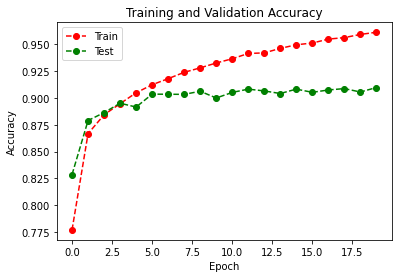

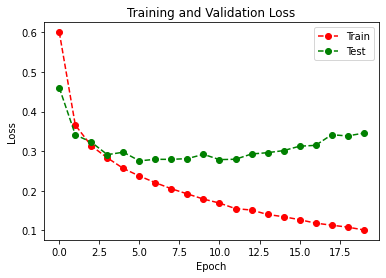

In [ ]:

plt.plot(range(num_epochs),Train_acc,'r--o')
plt.plot(range(num_epochs),accuracy_val,'g--o')
plt.title("Training and Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])

plt.figure()
plt.plot(range(num_epochs),train_loss,'r--o')
plt.plot(range(num_epochs),val_loss,'g--o')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'])


In the previous plot we see that after a number of epochs test loss starts to increase which shows that the network is overfiting the data. Therefor we implement L2 regularization method to see whether we can prevent 

In [11]:
torch.manual_seed(42)
model_L2 =Cnn(54,50,5,80,40,0.0153497).to(device)
optimizer = optim.Adam(model_L2.parameters(), lr = 0.00136,weight_decay=.001)

CNN has been initialized


In [ ]:
## TRAINING LOOP
num_epochs = 50
train_loss_log = []
val_loss_log = []
# optimizer = optim.Adam(net.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()
Train_acc = []
val_loss= []
accuracy_val = []
train_loss= []
for epoch_num in range(num_epochs):
    print(f'------------------------------------------ EPOCH {epoch_num + 1} -------------------------------')
    ###------------------------------ TRAIN --------------------------
    TrainLosstemp,TrainAccTemp = TrainCNN(model_L2, trainloader, optimizer)
    
    Train_acc.append(TrainAccTemp)
    #Save average train loss
    train_loss.append(TrainLosstemp)
    print(f"TRAIN LOSS: {TrainLosstemp}")
    
    
    #------------------------------ VALIDATION --------------------------

    lossTemp,accTemp = test_loss_Cnn(model_L2,validationloader)
    
    val_loss.append(lossTemp)
    accuracy_val.append(accTemp)
    print(f"VAL LOSS: {lossTemp}")
    print(f"VAL accuracy: {accTemp}")
    print(f"Training accuracy: {TrainAccTemp}")
    

------------------------------------------ EPOCH 1 -------------------------------
TRAIN LOSS: 0.6005493998527527
VAL LOSS: 0.416143536567688
VAL accuracy: 0.8504179936305732
Training accuracy: 0.7773337595907929
------------------------------------------ EPOCH 2 -------------------------------
TRAIN LOSS: 0.3834836483001709
VAL LOSS: 0.3559911847114563
VAL accuracy: 0.8726114649681529
Training accuracy: 0.859255115089514
------------------------------------------ EPOCH 3 -------------------------------
TRAIN LOSS: 0.33564597368240356
VAL LOSS: 0.3310977816581726
VAL accuracy: 0.8813694267515924
Training accuracy: 0.8768781969309463
------------------------------------------ EPOCH 4 -------------------------------
TRAIN LOSS: 0.31271693110466003
VAL LOSS: 0.31784749031066895
VAL accuracy: 0.8840565286624203
Training accuracy: 0.8853300831202046
------------------------------------------ EPOCH 5 -------------------------------
TRAIN LOSS: 0.295703649520874
VAL LOSS: 0.333776593208313
VA

In [ ]:
final_test_error,final_test_accuracy = test_loss_Cnn(model_L2,testloader)
print("-------------------------------------------------------------------")
print(f'final test accuracy of trained network is : {final_test_accuracy}')
print(f'final test error of trained network is : {final_test_error}')
print("-------------------------------------------------------------------")

-------------------------------------------------------------------
final test accuracy of trained network is : 0.9085390127388535
final test error of trained network is : 0.2682145833969116
-------------------------------------------------------------------


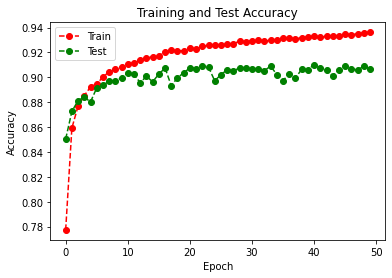

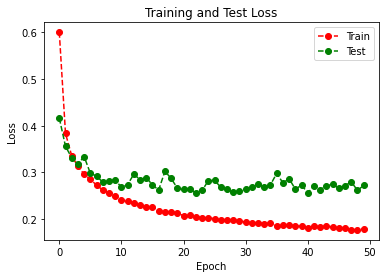

In [ ]:

plt.plot(range(num_epochs),Train_acc,'r--o')
plt.plot(range(num_epochs),accuracy_val,'g--o')
plt.title("Training and Test Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])

plt.figure()
plt.plot(range(num_epochs),train_loss,'r--o')
plt.plot(range(num_epochs),val_loss,'g--o')
plt.title("Training and Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'])

# Data Augmentation

In [10]:
train_list_transforms = [
        transforms.RandomHorizontalFlip(p=.7),
        transforms.ToTensor(),
        transforms.RandomRotation(15),
        transforms.RandomErasing(
                p=0.5,
                scale=(0.02, 0.25),
                ratio=(0.3, 2.3),
                value="random",
                inplace=False,
            ),
        transforms.Normalize((mean,), (std,))
    ]

transform = [
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,)),
    ]

augment_tr = transforms.Compose(train_list_transforms)
tr = transforms.Compose(transform)

In [11]:
full_dataset = torchvision.datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = tr)

train_dataset, val_dataset = random_split(full_dataset, (50000, 10000))

transform_dataset = torchvision.datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = augment_tr)
transform_dataset,_ = random_split(transform_dataset, (30000, 30000))


augmented_dataset = torch.utils.data.ConcatDataset([train_dataset, transform_dataset])
trainloader = torch.utils.data.DataLoader(augmented_dataset, batch_size = 64, shuffle = True)
## test data loader
test_dataset = torchvision.datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = tr)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)
# validation loader
validationloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = True)


In [12]:
print(len(augmented_dataset))

80000


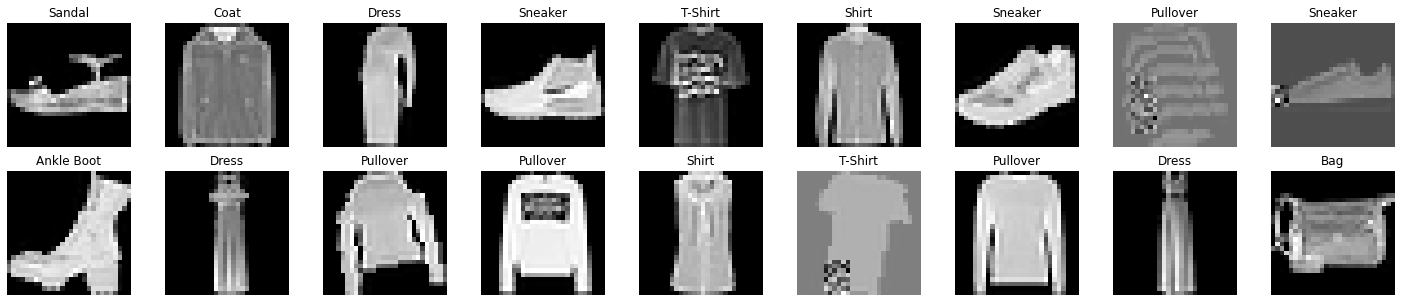

In [13]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
figure = plt.figure(figsize=(25,5))
cols, rows =  9,2
d = augmented_dataset
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(d), size=(1,)).item()
    img, label = d[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [14]:
torch.manual_seed(42)
model_augmented =Cnn(54,50,5,80,40,0.0153497).to(device)
optimizer = optim.Adam(model_augmented.parameters(), lr = 0.00136)

CNN has been initialized


In [17]:
## TRAINING LOOP
num_epochs = 21
train_loss_log = []
val_loss_log = []
# optimizer = optim.Adam(net.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()
Train_acc = []
val_loss= []
accuracy_val = []
train_loss= []
for epoch_num in range(num_epochs):
    print(f'------------------------------------------ EPOCH {epoch_num + 1} -------------------------------')
    ###------------------------------ TRAIN --------------------------
    TrainLosstemp,TrainAccTemp = TrainCNN(model_augmented, trainloader, optimizer)
    
    Train_acc.append(TrainAccTemp)
    #Save average train loss
    train_loss.append(TrainLosstemp)
    print(f"TRAIN LOSS: {TrainLosstemp}")
    #------------------------------ VALIDATION --------------------------

    lossTemp,accTemp = test_loss_Cnn(model_augmented,validationloader)
    
    val_loss.append(lossTemp)
    accuracy_val.append(accTemp)
    print(f"Training accuracy: {TrainAccTemp}")
    print("")
    print(f"VAL LOSS: {lossTemp}")
    print(f"VAL accuracy: {accTemp}")
    

------------------------------------------ EPOCH 1 -------------------------------
TRAIN LOSS: 0.6005374193191528
Training accuracy: 0.77605

VAL LOSS: 0.3587208688259125
VAL accuracy: 0.8675358280254777
------------------------------------------ EPOCH 2 -------------------------------
TRAIN LOSS: 0.41600605845451355
Training accuracy: 0.84655

VAL LOSS: 0.31058672070503235
VAL accuracy: 0.8840565286624203
------------------------------------------ EPOCH 3 -------------------------------
TRAIN LOSS: 0.37295234203338623
Training accuracy: 0.8620625

VAL LOSS: 0.2802917957305908
VAL accuracy: 0.8974920382165605
------------------------------------------ EPOCH 4 -------------------------------
TRAIN LOSS: 0.35194432735443115
Training accuracy: 0.8691

VAL LOSS: 0.27162986993789673
VAL accuracy: 0.904359076433121
------------------------------------------ EPOCH 5 -------------------------------
TRAIN LOSS: 0.3299187123775482
Training accuracy: 0.8760875

VAL LOSS: 0.25817176699638367
VAL a

In [18]:
final_test_error,final_test_accuracy = test_loss_Cnn(model_augmented,testloader)
print("-------------------------------------------------------------------")
print(f'final test accuracy of trained network is : {final_test_accuracy}')
print(f'final test error of trained network is : {final_test_error}')
print("-------------------------------------------------------------------")

-------------------------------------------------------------------
final test accuracy of trained network is : 0.9126194267515924
final test error of trained network is : 0.26786455512046814
-------------------------------------------------------------------


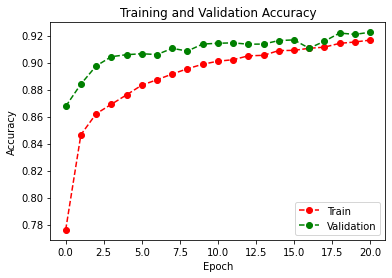

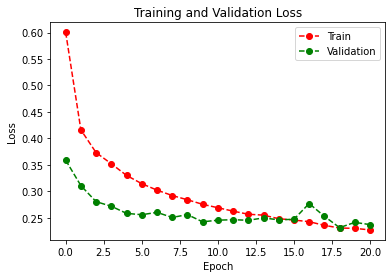

In [19]:
plt.plot(range(num_epochs),Train_acc,'r--o')
plt.plot(range(num_epochs),accuracy_val,'g--o')
plt.title("Training and Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

plt.figure()
plt.plot(range(num_epochs),train_loss,'r--o')
plt.plot(range(num_epochs),val_loss,'g--o')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])

## Confusion Matrix
In this section I plotted the confusion matrix for the network which has been trained on augmented data

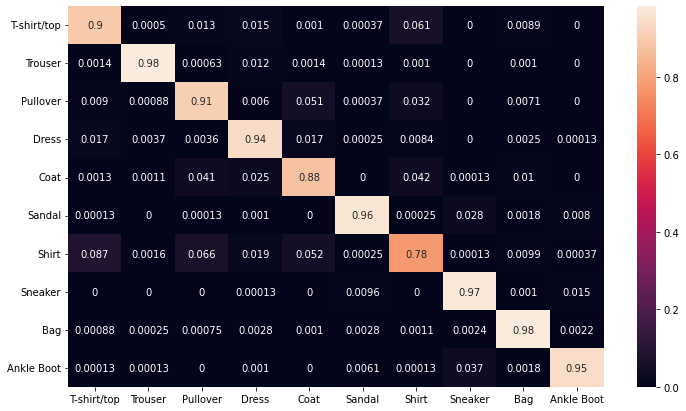

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in trainloader:
        output = model_augmented(inputs.to(device)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

## Weight histograms
In this part I visualized the weight histograms of fully connected layers of CNN Before and after training.
Weight historgrams after training are for the network trained on Augmented data.

CNN has been initialized


Text(0.5, 1.0, 'weights of layer two')

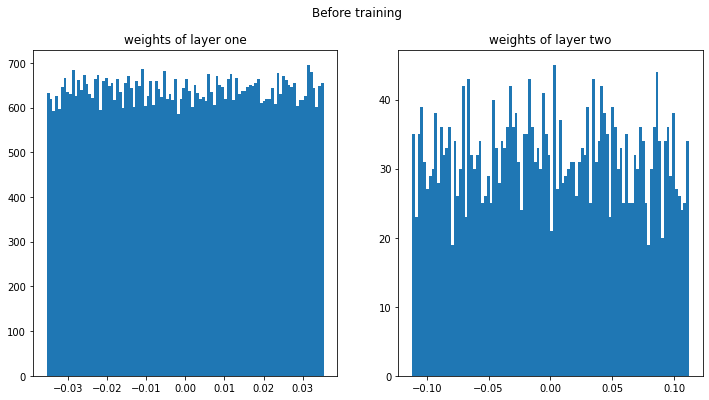

<Figure size 432x288 with 0 Axes>

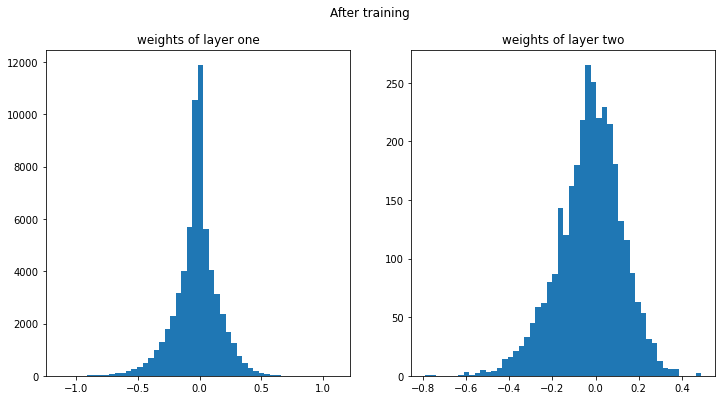

In [22]:
torch.manual_seed(42)
net1 = Cnn(54,50,5,80,40,0.0153497)
layer1 = net1.fc1.weight.detach().numpy()
layer2 = net1.fc2.weight.detach().numpy()
fig1, axs1 = plt.subplots(1,2)
fig1.suptitle('Before training')
# fig.suptitle('Vertically stacked subplots')
fig1.set_figwidth(12)
fig1.set_figheight(6)
axs1[0].hist(layer1.flatten(), 100)
axs1[0].set_title('weights of layer one')
axs1[1].hist(layer2.flatten(), 100)
axs1[1].set_title('weights of layer two')

plt.figure()
fig, axs = plt.subplots(1,2)
fig.suptitle('After training')
fig.set_figwidth(12)
fig.set_figheight(6)
l1 = model_augmented.fc1.weight.cpu().detach().numpy()
l2 = model_augmented.fc2.weight.cpu().detach().numpy()
axs[0].hist(l1.flatten(), 50)
axs[0].set_title('weights of layer one')
axs[1].hist(l2.flatten(), 50)
axs[1].set_title('weights of layer two')

## visualizing the filters of convolutional layers

In [23]:
print(model_augmented)

Cnn(
  (conv1): Conv2d(1, 54, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(54, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (out): Linear(in_features=40, out_features=10, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.0153497, inplace=False)
)


### filters of layer one

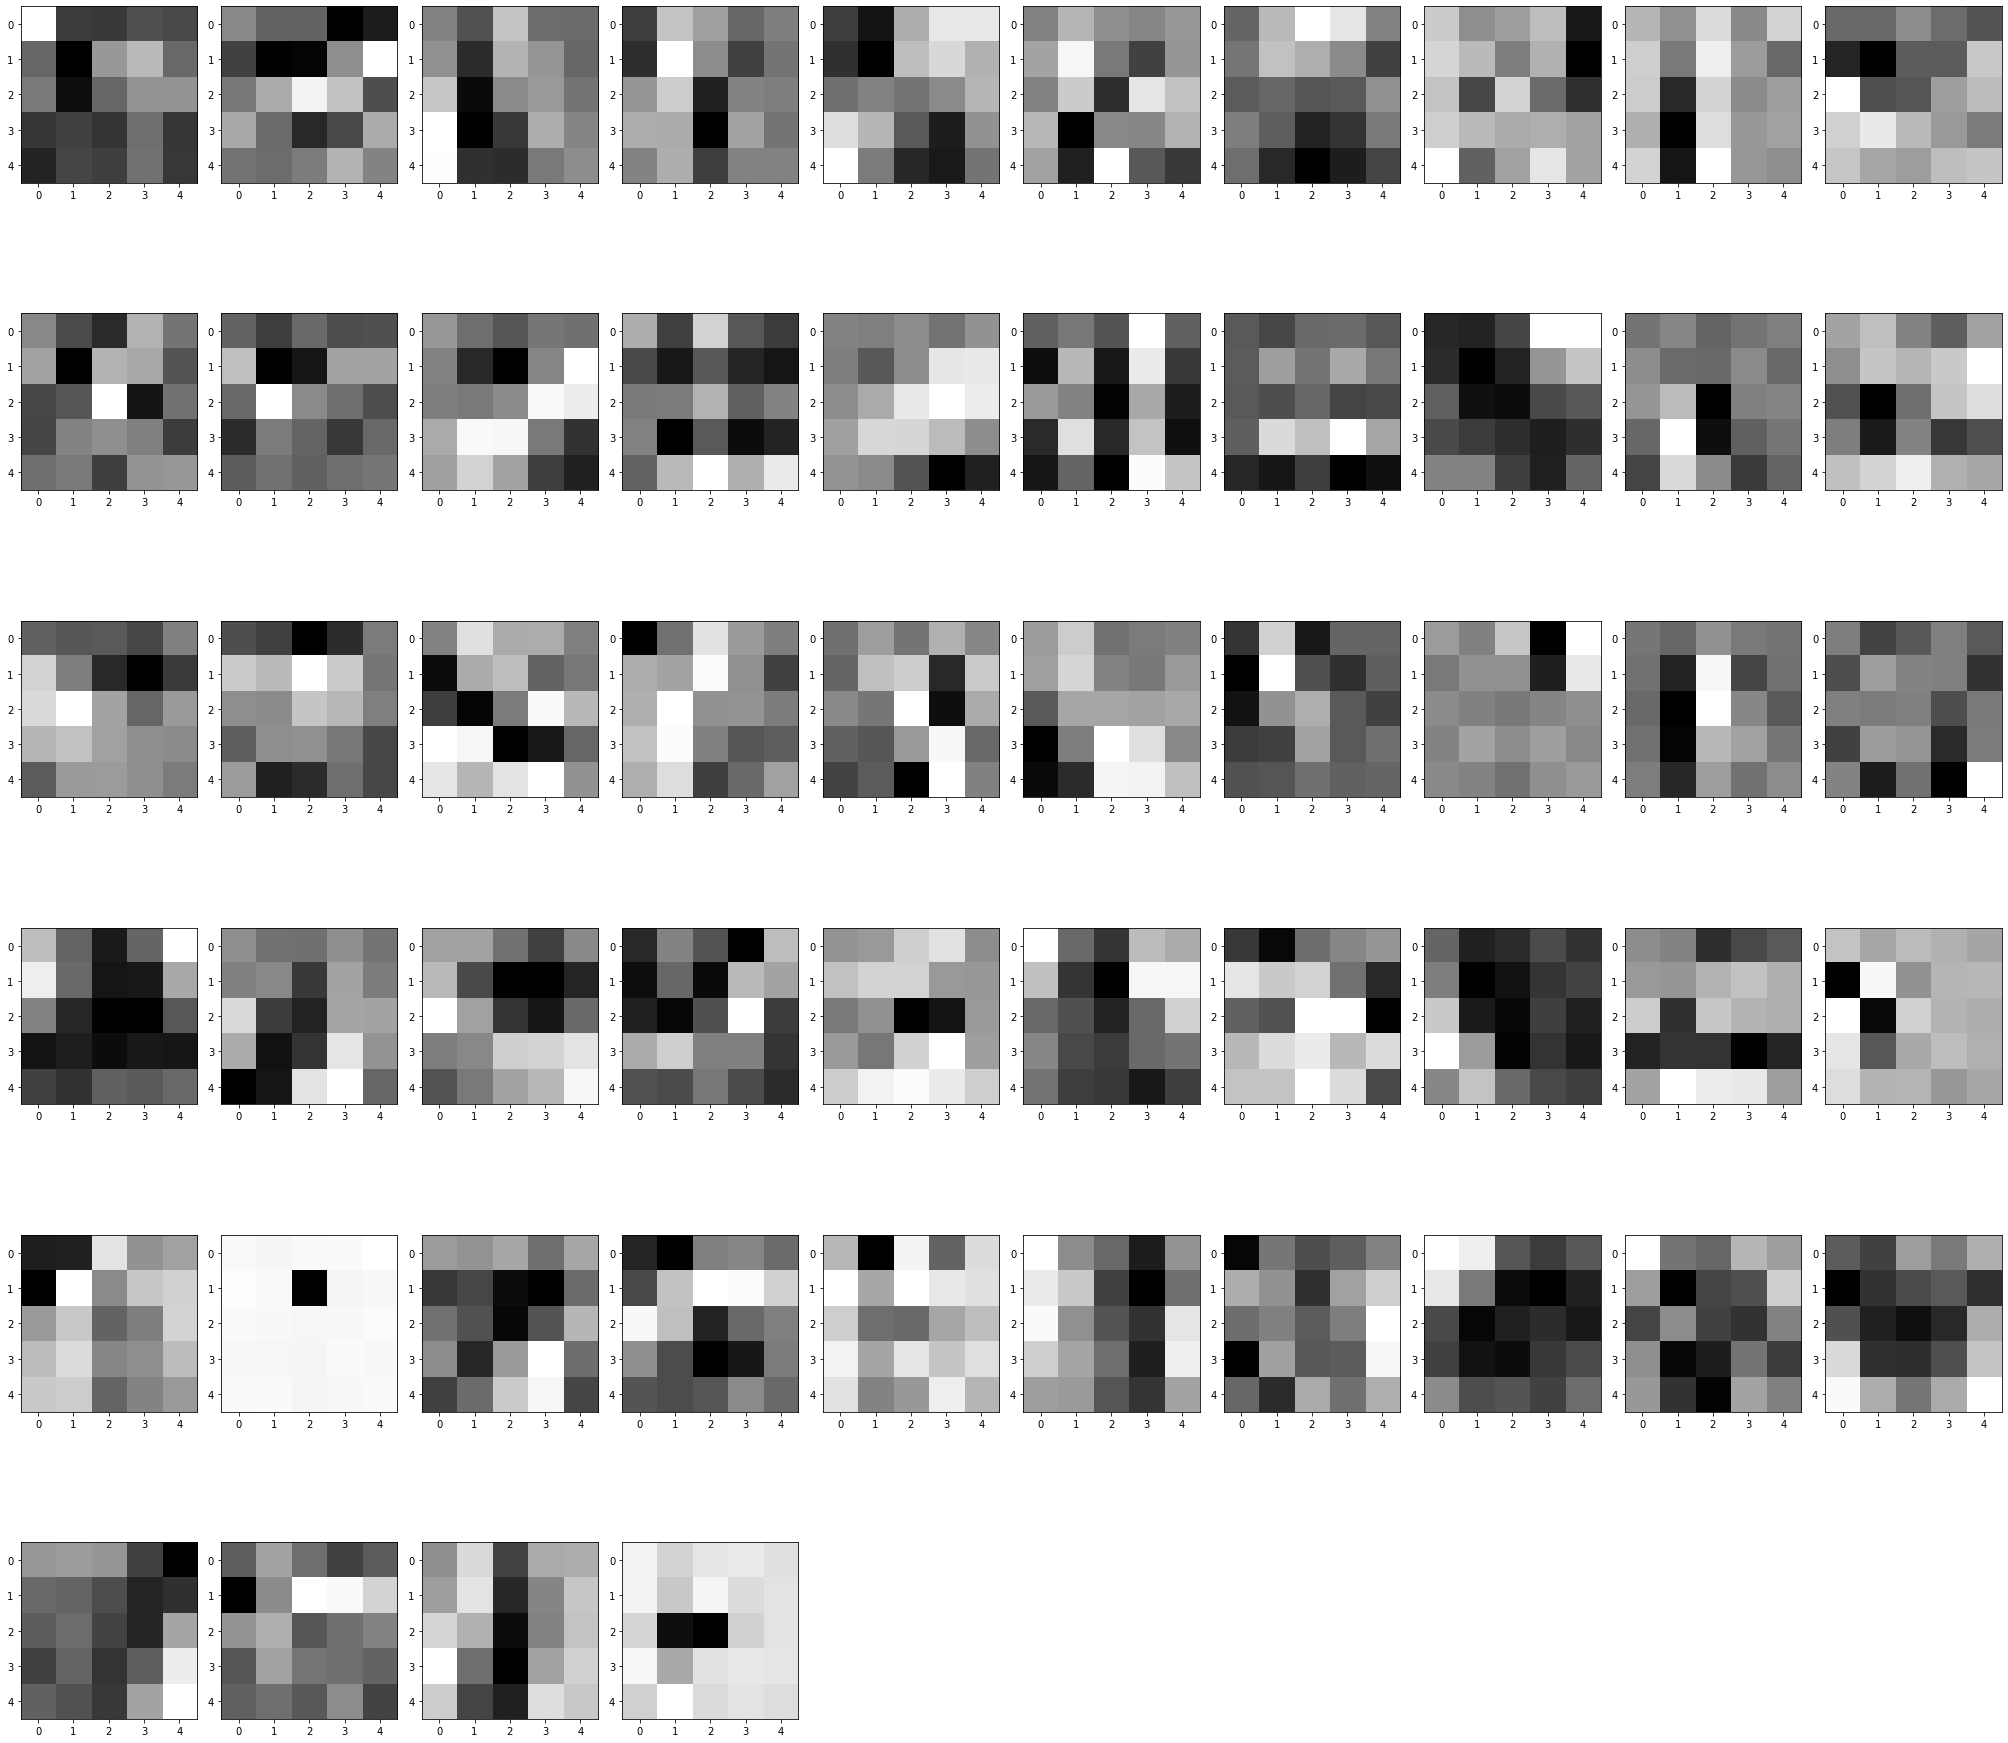

In [ ]:
Filter = []
Filter.append(model_augmented.conv1.weight)
rows = int(model_augmented.conv2.weight.shape[0]/10) + 1
cols = 10
width=15
height=15
axes=[]
fig=plt.figure(figsize=(28, 26))

for j in Filter:
    for i in range(j.shape[0]):
      b = j[i,:,:,:]
      axes.append( fig.add_subplot(rows, cols, i+1) )
      # subplot_title=("Subplot"+str(a))
      # axes[-1].set_title(subplot_title)  
      plt.imshow(b[0,:,:].cpu().detach().numpy(),cmap = 'gray')
fig.tight_layout()

### Filters of layer two

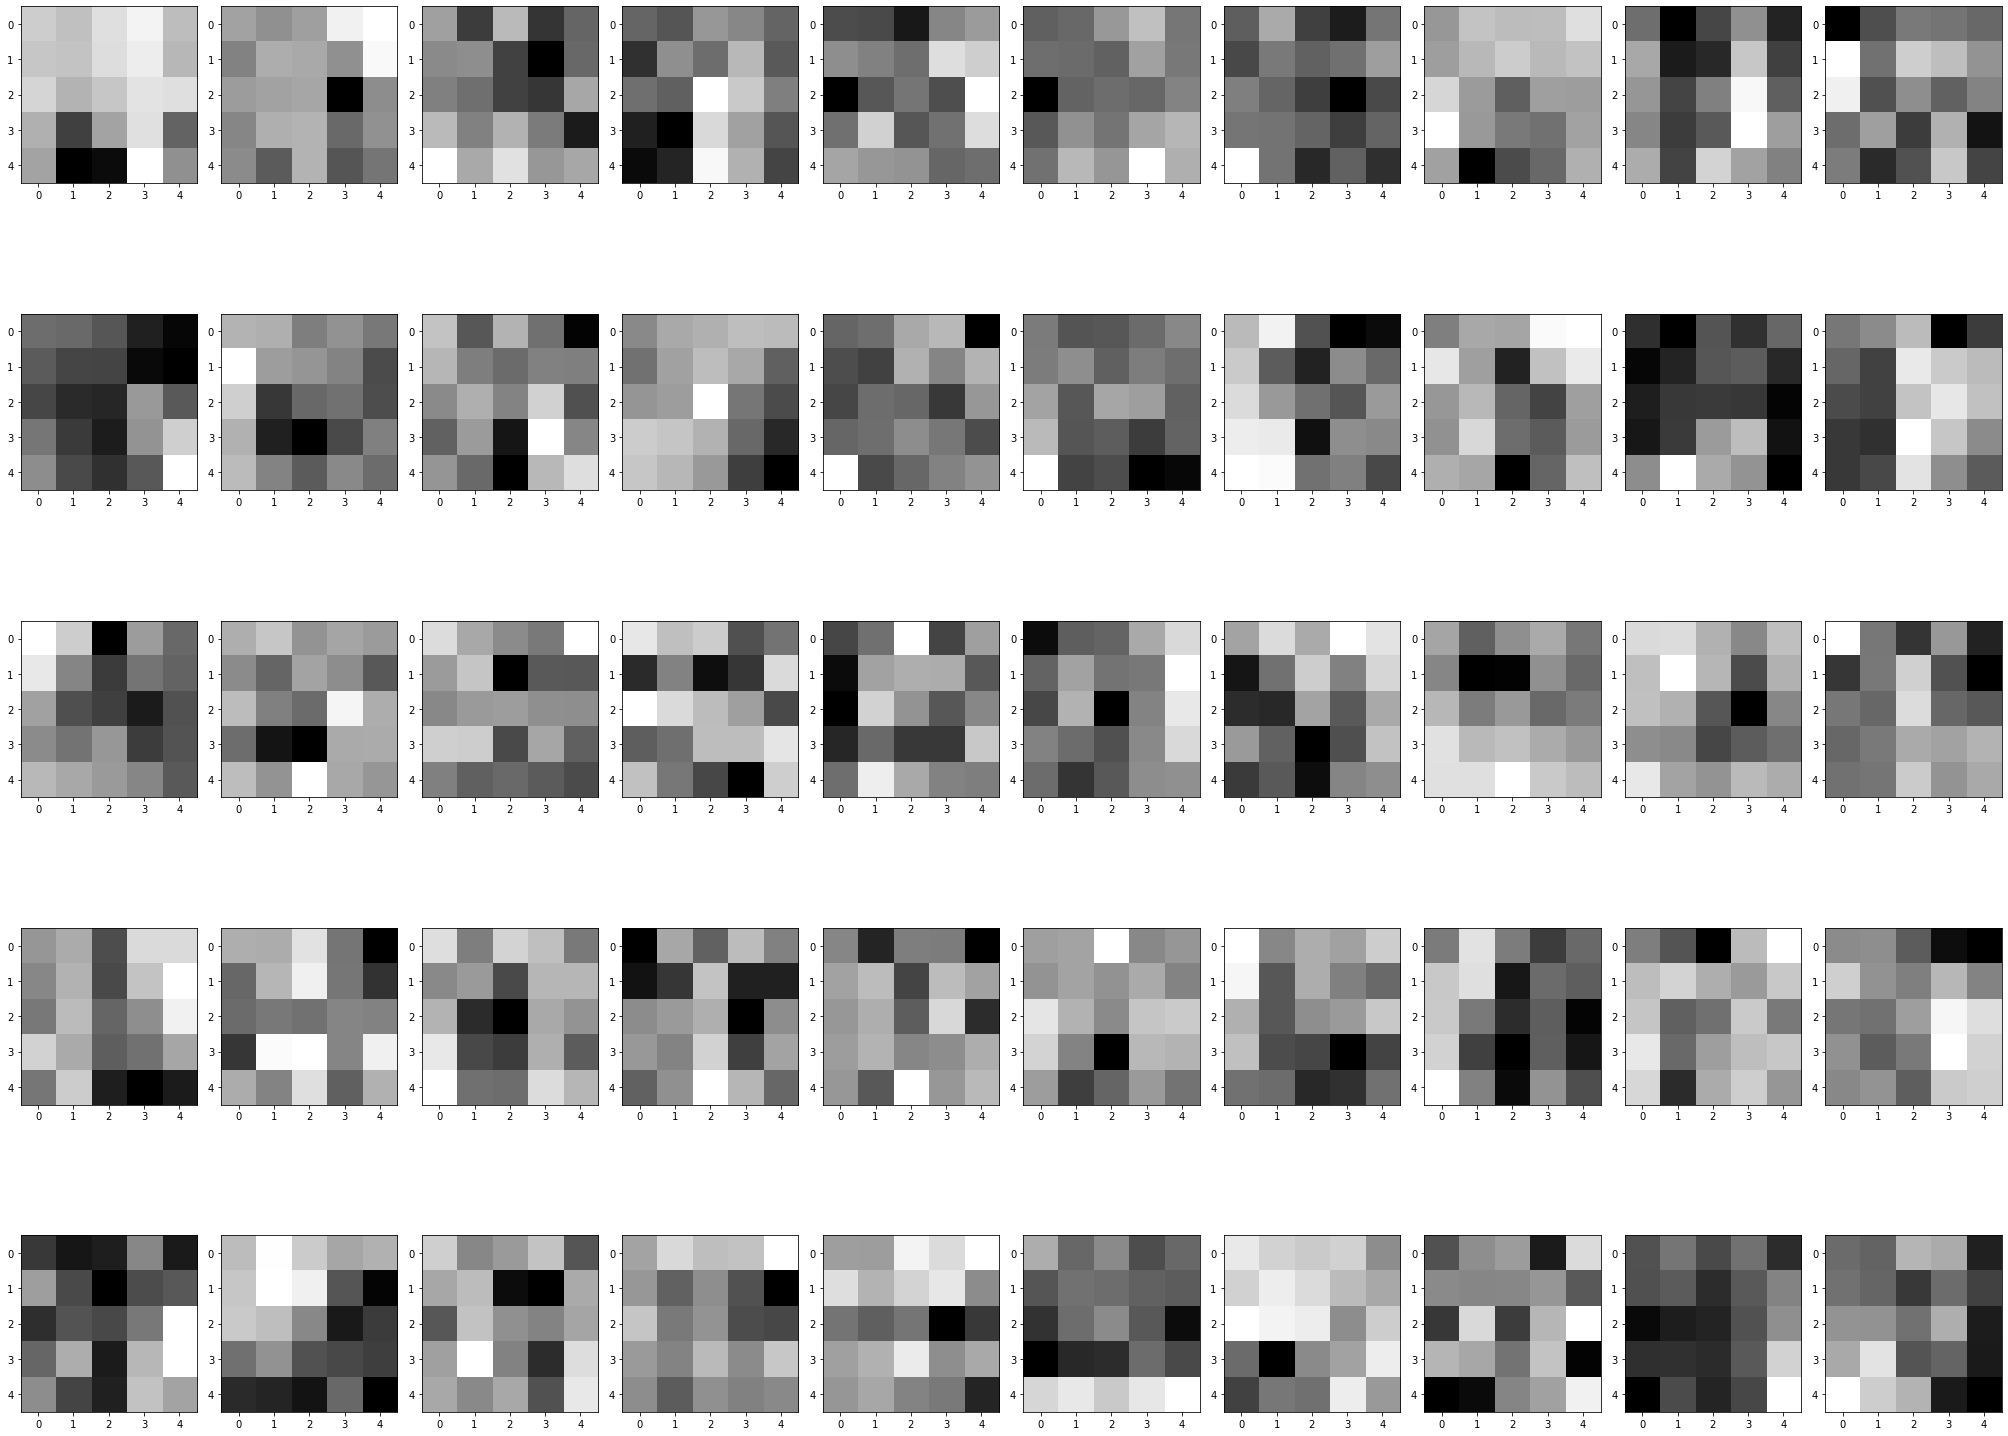

In [ ]:
Filter = []
Filter.append(model_augmented.conv2.weight)
rows = int(model_augmented.conv2.weight.shape[0]/10) + 1
cols = 10
width=15
height=15
axes=[]
fig=plt.figure(figsize=(28, 26))

for j in Filter:
    for i in range(j.shape[0]):
      b = j[i,:,:,:]
      axes.append( fig.add_subplot(rows, cols, i+1) )
      # subplot_title=("Subplot"+str(a))
      # axes[-1].set_title(subplot_title)  
      plt.imshow(b[0,:,:].cpu().detach().numpy(),cmap = 'gray')
fig.tight_layout()

In the following section I chose an image from test data set and visualized the output of each filter for that particular image

In [ ]:
img, _ = next(iter(testloader))

no_of_layers=0
conv_layers=[]

model_children=list(model_augmented.children())
for child in model_children:
    if type(child)==nn.Conv2d:
        no_of_layers += 1
        conv_layers.append(child)
    # elif type(child)==nn.Sequential:
    #     for layer in child.children():
    #         if type(layer)==nn.Conv2d:
    #             no_of_layers+=1
    #             conv_layers.append(layer)
print(no_of_layers)
# img = np.squeeze(img[1,:,:,:])

2


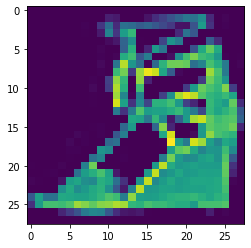

In [ ]:
plt.imshow(np.squeeze(img[0,:,:,:]))

In [ ]:
results = [conv_layers[0](img.to(device))]
for i in range(1, len(conv_layers)):
    #in the following line of code the output of previous layer is given to the next one
    results.append(conv_layers[i](results[-1]))
outputs = results
print(len(results))

2


Layer  1
Layer  2


<Figure size 2016x1872 with 0 Axes>

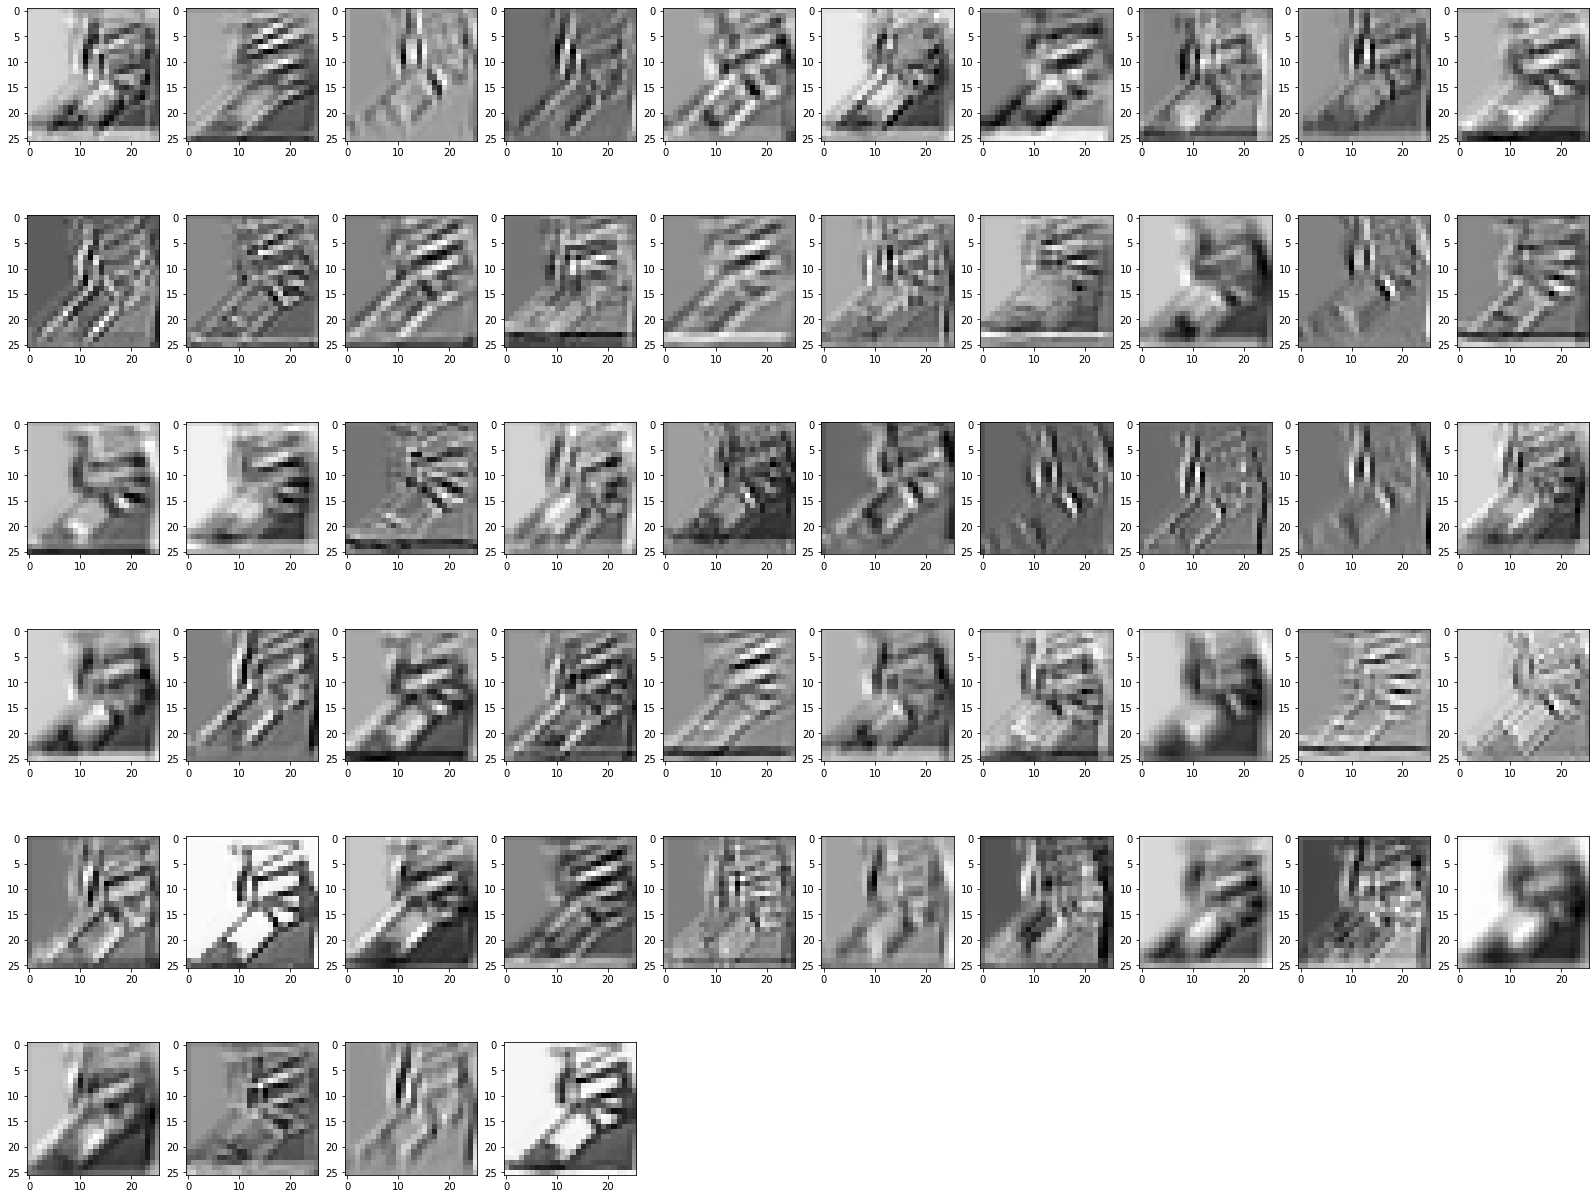

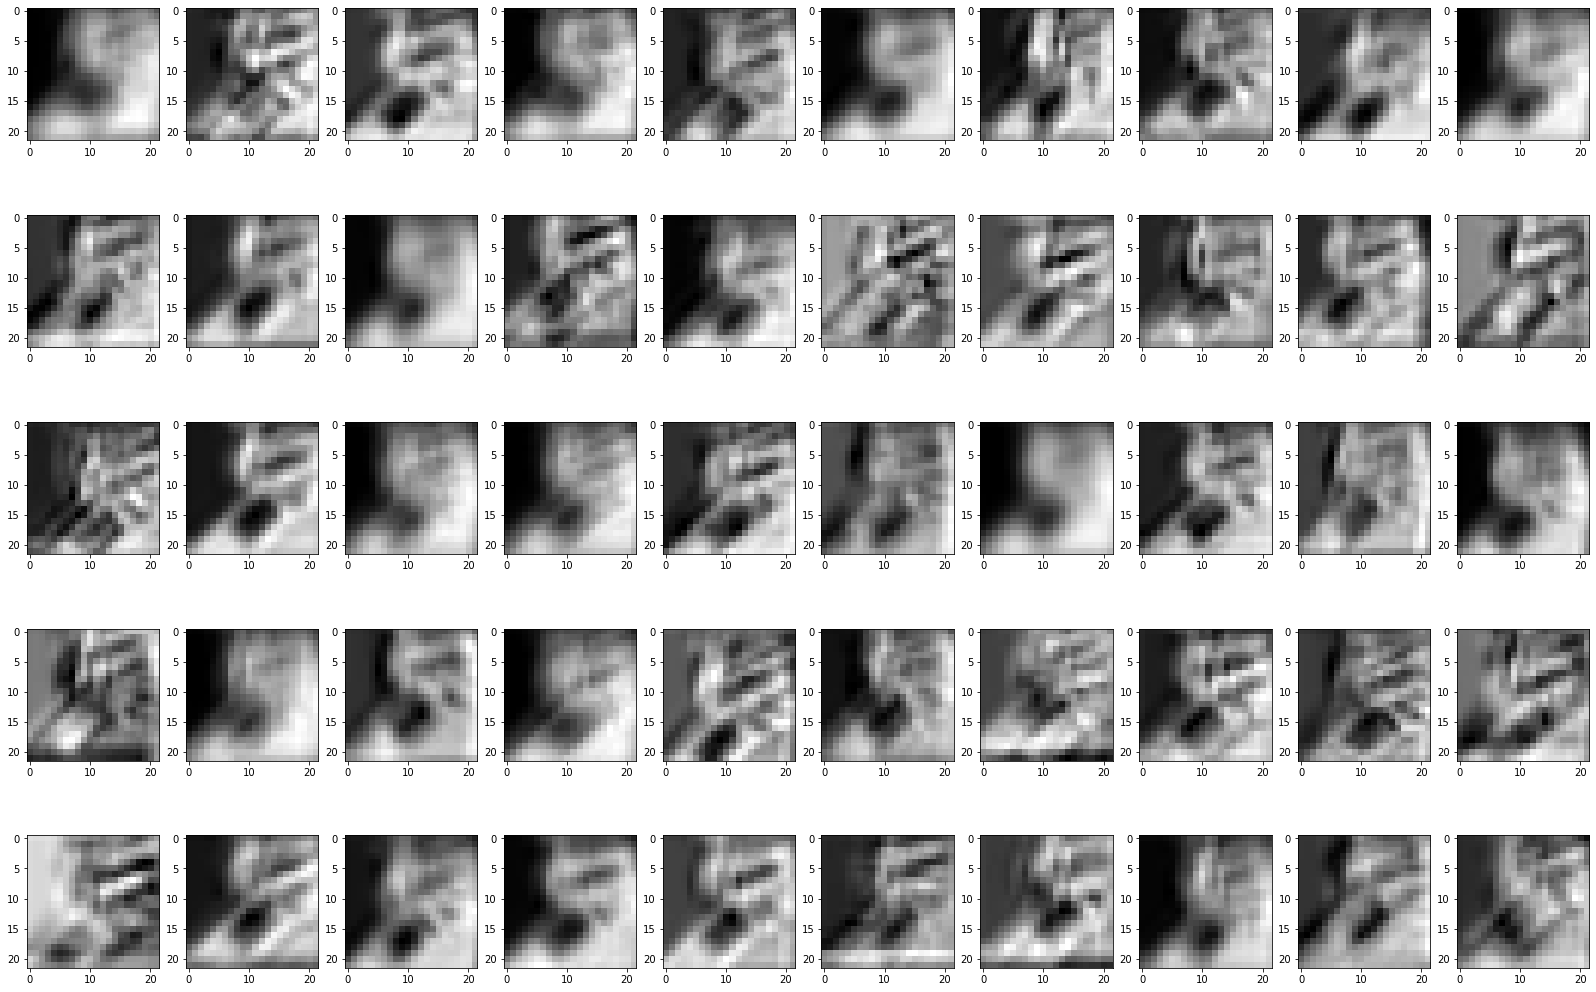

In [ ]:
Filter = []
Filter.append(model_augmented.conv2.weight)
rows = int(model_augmented.conv2.weight.shape[0]/10) + 1
cols = 10
width=15
height=15
axes=[]
fig=plt.figure(figsize=(28, 26))

for num_layer in range(len(outputs)):
    fig=plt.figure(figsize=(28, 26))
    cols = 10
    rows = int(len(outputs[num_layer])/10)+1
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, fiter in enumerate(layer_viz):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        # plt.
        plt.imshow(fiter.cpu(), cmap='gray')


# Grad-cam

In [ ]:
print(model_augmented)

Cnn(
  (conv1): Conv2d(1, 54, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(54, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (out): Linear(in_features=40, out_features=10, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.0153497, inplace=False)
)


In [45]:
## TRAINING LOOP
num_epochs = 21
train_loss_log = []
val_loss_log = []
# optimizer = optim.Adam(net.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()
Train_acc = []
val_loss= []
accuracy_val = []
train_loss= []
for epoch_num in range(num_epochs):
    print(f'------------------------------------------ EPOCH {epoch_num + 1} -------------------------------')
    ###------------------------------ TRAIN --------------------------
    TrainLosstemp,TrainAccTemp = TrainCNN(model_augmented, trainloader, optimizer)
    
    Train_acc.append(TrainAccTemp)
    #Save average train loss
    train_loss.append(TrainLosstemp)
    print(f"TRAIN LOSS: {TrainLosstemp}")
    #------------------------------ VALIDATION --------------------------

    lossTemp,accTemp = test_loss_Cnn(model_augmented,validationloader)
    
    val_loss.append(lossTemp)
    accuracy_val.append(accTemp)
    print(f"Training accuracy: {TrainAccTemp}")
    print("")
    print(f"VAL LOSS: {lossTemp}")
    print(f"VAL accuracy: {accTemp}")
    

------------------------------------------ EPOCH 1 -------------------------------
TRAIN LOSS: 0.5968739986419678
Training accuracy: 0.776625

VAL LOSS: 0.3514254093170166
VAL accuracy: 0.8727109872611465
------------------------------------------ EPOCH 2 -------------------------------
TRAIN LOSS: 0.41245323419570923
Training accuracy: 0.8473875

VAL LOSS: 0.32778123021125793
VAL accuracy: 0.884952229299363
------------------------------------------ EPOCH 3 -------------------------------
TRAIN LOSS: 0.36908087134361267
Training accuracy: 0.8633875

VAL LOSS: 0.2958357632160187
VAL accuracy: 0.8915207006369427
------------------------------------------ EPOCH 4 -------------------------------
TRAIN LOSS: 0.3441215455532074
Training accuracy: 0.873025

VAL LOSS: 0.27398794889450073
VAL accuracy: 0.9018710191082803
------------------------------------------ EPOCH 5 -------------------------------
TRAIN LOSS: 0.32793179154396057


KeyboardInterrupt: ignored

In [46]:
class CNN(nn.Module):
    def __init__(self):
        """
            numFilters1 is number of filters in the first convolutional layer
            numFilters2 is number of filters in the second convolutional layer

            kernel is the size for kernels used in convolutional layer

            fc1 is number of neurons in the first fully connected layer after convolutional leyars
            fc2 is number of neurons in the second fully connected layer after convolutional leyars
        """
        super().__init__()
        self.conv1 = model_augmented.conv1
        self.conv2 = model_augmented.conv2
        self.gradients = None
        # self.w1 = (28 - kernel +2*1 + 1)/2
        # self.w2 = int((self.w1 - kernel + 1)/2)
#         print(self.w2)
        self.fc1 = model_augmented.fc1
        self.fc2 = model_augmented.fc2
        self.out = model_augmented.out
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.0153497)
        print('CNN has been initialized')
    def activations_hook(self, grad):
        self.gradients = grad
    def forward(self,x):
        x = self.act(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = self.act(self.conv2(x))
        # register the hook
        h = x.register_hook(self.activations_hook)

        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.shape[0], -1)
        x = self.dropout(self.act(self.fc1(x)))
        x = self.dropout(self.act(self.fc2(x)))
        x = self.out(x)
        return x  
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        x = self.act(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = self.act(self.conv2(x))
        return x

CNN has been initialized
tensor(8)


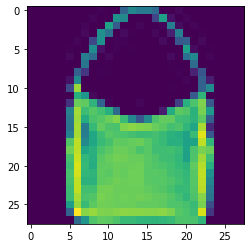

In [115]:
net = CNN()

img,label = next(iter(testloader))
print(label[0])

Img = np.squeeze(img[0,:,:])
plt.imshow(Img)
img = torch.unsqueeze(Img,dim=0)
img = torch.unsqueeze(img,dim=0).to(device)


In [116]:
pred = net(img)#.argmax(dim=1)


In [117]:
print(pred.argmax(dim=1))
print(np.shape(pred))

tensor([8])
torch.Size([1, 10])


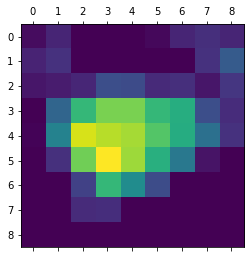

In [118]:
pred[:,label[0]].backward()

# pull the gradients out of the model
gradients = net.get_activations_gradient()

# pool the gradients across the channels
# print(gradients)
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = net.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(50):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = np.maximum(heatmap.cpu(), 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())


In [119]:
import cv2
from PIL import Image
tra = transforms.ToPILImage()
heatmap = tra(heatmap)
# out = F.interpolate(heatmap, size=(28, 28), mode='bicubic', align_corners=False)
new_image = heatmap.resize((28, 28))

tra = transforms.ToTensor()
heatmap = tra(new_image)
superimposed_img = heatmap * 1 + Img

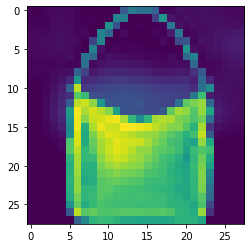

In [120]:
plt.imshow(superimposed_img[0,:,:])
